## Environment setup

### Install dependencies

Installs RF-DETR version 1.4.0 or higher, along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [12]:
!pip install rfdetr>=1.4.0 supervision roboflow inference tqdm matplotlib opencv-python

zsh:1: 1.4.0 not found


In [ ]:
!pip install torch==2.8.0+cu128  --index-url https://download.pytorch.org/whl/cu128

In [ ]:
!pip install git+https://github.com/roboflow/rf-detr.git

In [ ]:
!pip3 install git+https://github.com/laudominik/torch-arcade

## Convert Arcade dataset to coco

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import shutil
from tqdm import tqdm
from dataclasses import dataclass, field

from typing import Callable, Optional, Union, Dict, List, Any, Tuple
from pathlib import Path
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

try:
    import albumentations as A
except ImportError:
    A = None

try:
    import cv2
except ImportError:
    cv2 = None

    
def distinguish_side(segments):
    """Determine side based on vessel segments."""
    right_segments = {"1", "2", "3", "4", "16a", "16b", "16c"}
    return "right" if any(seg in segments for seg in right_segments) else "left"


@dataclass
class AugmentationParams:
    """
    Parameters for data augmentation during COCO dataset conversion.
    All probabilities default to 0 (disabled). Set > 0 to enable.
    """
    # Basic augmentations
    apply_augmentation: bool = False
    augmentation_factor: int = 1  # Number of augmented copies per original image
    
    # Flip augmentations
    horizontal_flip_p: float = 0.0
    vertical_flip_p: float = 0.0
    random_rotate_90_p: float = 0.0
    
    # Rotation
    rotate_p: float = 0.0
    rotate_limit: int = 15
    
    # Elastic/distortion augmentations
    elastic_transform_p: float = 0.0
    elastic_transform_alpha: float = 120.0
    elastic_transform_sigma: float = 6.0
    
    grid_distortion_p: float = 0.0
    optical_distortion_p: float = 0.0
    optical_distortion_limit: float = 0.05
    
    # Color/brightness augmentations
    random_brc_p: float = 0.0
    random_brc_b_limit: float = 0.2
    random_brc_c_limit: float = 0.2
    
    # Noise/blur
    gauss_noise_p: float = 0.0
    blur_p: float = 0.0
    blur_limit: int = 3
    
    # Spatial augmentations
    random_resized_crop_p: float = 0.0
    random_resized_crop_scale: Tuple[float, float] = (0.8, 1.0)
    random_resized_crop_ratio: Tuple[float, float] = (0.9, 1.1)
    
    shift_scale_rotate_p: float = 0.0
    shift_scale_rotate_shift_limit: float = 0.1
    shift_scale_rotate_scale_limit: float = 0.1


class ARCADEtoCocoConverter:
    """
    Converts ARCADE segmentation dataset to COCO detection format for RF-DETR.
    
    This converter reads the ARCADE dataset with segmentation masks and exports
    images and annotations in COCO format suitable for object detection training.
    Supports optional augmentations during conversion.
    
    Output structure:
        dataset/
        ├── train/
        │   ├── _annotations.coco.json
        │   └── *.png
        ├── valid/
        │   ├── _annotations.coco.json
        │   └── *.png
        └── test/
            ├── _annotations.coco.json
            └── *.png
    """
    
    URL: str = "https://zenodo.org/records/8386059/files/arcade_challenge_datasets.zip"
    ZIPNAME: str = "arcade_challenge_datasets.zip"
    FILENAME: str = "arcade_challenge_datasets"
    
    # Mapping from internal split names to output folder names
    OUTPUT_SPLIT_NAMES = {
        "train": "train",
        "val": "valid",
        "test": "test",
    }
    
    DATASET_DICT = {
        "segmentation": {
            "train": {
                "path": os.path.join("dataset_phase_1", "segmentation_dataset", "seg_train"),
                "coco": "seg_train.json",
            },
            "val": {
                "path": os.path.join("dataset_phase_1", "segmentation_dataset", "seg_val"),
                "coco": "seg_val.json"
            },
            "test": {
                "path": os.path.join("dataset_final_phase", "test_case_segmentation"),
                "coco": "instances_default.json"
            }
        },
        "stenosis": {
            "train": {
                "path": os.path.join("dataset_phase_1", "stenosis_dataset", "sten_train"),
                "coco": "sten_train.json"
            },
            "val": {
                "path": os.path.join("dataset_phase_1", "stenosis_dataset", "sten_val"),
                "coco": "sten_val.json"
            },
            "test": {
                "path": os.path.join("dataset_final_phase", "test_cases_stenosis"),
                "coco": "instances_default.json"
            }
        },
    }

    def __init__(
        self,
        root: Union[str, Path],
        output_dir: Union[str, Path],
        download: bool = False,
        task_type: str = "multiclass",
        min_area: float = 10.0,
        copy_images: bool = True,
        augmentation_params: Optional[AugmentationParams] = None,
        image_size: int = 512,
    ) -> None:
        """
        Initialize the ARCADE to COCO converter.
        
        Args:
            root: Root directory containing ARCADE dataset
            output_dir: Output directory for COCO format dataset
            download: Whether to download ARCADE dataset if not present
            task_type: "binary", "multiclass", or "stenosis"
            min_area: Minimum bounding box area to include annotation
            copy_images: If True, copies images; if False, creates symlinks
            augmentation_params: Optional augmentation parameters (only for train)
            image_size: Target image size for augmentations
        """
        self.root = Path(root)
        self.output_dir = Path(output_dir)
        self.task_type = task_type
        self.min_area = min_area
        self.copy_images = copy_images
        self.augmentation_params = augmentation_params
        self.image_size = image_size
        
        # Determine which ARCADE dataset folder to use
        if self.task_type == "stenosis":
            self._dataset_task = "stenosis"
        else:
            self._dataset_task = "segmentation"
        
        # Download if needed
        if download:
            download_and_extract_archive(self.URL, str(self.root), filename=self.ZIPNAME)
        
        # Category mapping will be built during conversion
        self.category_id_to_class_idx: Dict[int, int] = {}
        self.coco_categories: List[Dict[str, Any]] = []
        
        # Build augmentation pipeline if needed
        self.augs = None
        if augmentation_params and augmentation_params.apply_augmentation:
            if A is None:
                raise ImportError("Albumentations required for augmentations (pip install albumentations)")
            self.augs = self._build_augmentation_pipeline(augmentation_params)
    
    def _build_augmentation_pipeline(self, p: AugmentationParams) -> Any:
        """Build albumentations pipeline for bounding box augmentation."""
        aug_list: List[Any] = []
        
        if p.horizontal_flip_p > 0:
            aug_list.append(A.HorizontalFlip(p=p.horizontal_flip_p))
        if p.vertical_flip_p > 0:
            aug_list.append(A.VerticalFlip(p=p.vertical_flip_p))
        if p.random_rotate_90_p > 0:
            aug_list.append(A.RandomRotate90(p=p.random_rotate_90_p))
        
        if p.rotate_p > 0 and p.rotate_limit != 0:
            aug_list.append(A.Rotate(
                limit=p.rotate_limit, 
                p=p.rotate_p, 
                border_mode=0,
                interpolation=cv2.INTER_LINEAR if cv2 else 1,
            ))

        if p.elastic_transform_p > 0:
            aug_list.append(
                A.ElasticTransform(
                    alpha=p.elastic_transform_alpha,
                    sigma=p.elastic_transform_sigma,
                    p=p.elastic_transform_p,
                    border_mode=0,
                )
            )
        if p.grid_distortion_p > 0:
            aug_list.append(A.GridDistortion(
                p=p.grid_distortion_p, 
                border_mode=0,
            ))
        if p.optical_distortion_p > 0:
            aug_list.append(
                A.OpticalDistortion(
                    distort_limit=p.optical_distortion_limit,
                    shift_limit=0.05,
                    p=p.optical_distortion_p,
                )
            )
        if p.random_brc_p > 0:
            aug_list.append(
                A.RandomBrightnessContrast(
                    brightness_limit=p.random_brc_b_limit,
                    contrast_limit=p.random_brc_c_limit,
                    p=p.random_brc_p,
                )
            )
        if p.gauss_noise_p > 0:
            aug_list.append(A.GaussNoise(p=p.gauss_noise_p))
        if p.blur_p > 0:
            aug_list.append(A.Blur(blur_limit=int(p.blur_limit), p=p.blur_p))
        
        if p.random_resized_crop_p > 0:
            aug_list.append(
                A.RandomResizedCrop(
                    size=(self.image_size, self.image_size),
                    scale=p.random_resized_crop_scale,
                    ratio=p.random_resized_crop_ratio,
                    p=p.random_resized_crop_p
                )
            )
        
        if p.shift_scale_rotate_p > 0:
            aug_list.append(
                A.Affine(
                    translate_percent={
                        "x": (-p.shift_scale_rotate_shift_limit, p.shift_scale_rotate_shift_limit),
                        "y": (-p.shift_scale_rotate_shift_limit, p.shift_scale_rotate_shift_limit)
                    },
                    scale=(1 - p.shift_scale_rotate_scale_limit, 1 + p.shift_scale_rotate_scale_limit),
                    rotate=0,
                    p=p.shift_scale_rotate_p
                )
            )
        
        if not aug_list:
            return None
            
        return A.Compose(
            aug_list,
            bbox_params=A.BboxParams(
                format='coco',
                label_fields=['category_ids'],
                min_area=self.min_area,
                min_visibility=0.3,
            )
        )
        
    def _build_category_mapping(self, coco: COCO) -> None:
        """Build category mapping based on task type."""
        categories = coco.loadCats(coco.getCatIds())
        categories = sorted(categories, key=lambda cat: cat["id"])
        
        if self.task_type == "stenosis":
            stenosis_cat = next((cat for cat in categories if cat["name"] == "stenosis"), None)
            if stenosis_cat is None:
                raise ValueError("Stenosis category not found in dataset")
            
            self.category_id_to_class_idx = {stenosis_cat["id"]: 1}
            self.coco_categories = [{
                "id": 1,
                "name": "stenosis",
                "supercategory": "vessel"
            }]
            print(f"Stenosis mode: 1 category (stenosis)")
            
        elif self.task_type == "multiclass":
            EXCLUDED_CATEGORIES = {26}  # stenosis not used in vessel segmentation
            
            self.category_id_to_class_idx = {}
            self.coco_categories = []
            contiguous_idx = 1
            
            for category in categories:
                if category["id"] not in EXCLUDED_CATEGORIES:
                    self.category_id_to_class_idx[category["id"]] = contiguous_idx
                    self.coco_categories.append({
                        "id": contiguous_idx,
                        "name": category["name"],
                        "supercategory": category.get("supercategory", "vessel")
                    })
                    contiguous_idx += 1
            
            print(f"Multiclass mode: {len(self.coco_categories)} categories")
            
        else:  # binary
            self.category_id_to_class_idx = {}
            self.coco_categories = [{
                "id": 1,
                "name": "vessel",
                "supercategory": "vessel"
            }]
            for category in categories:
                if category["name"] != "stenosis":
                    self.category_id_to_class_idx[category["id"]] = 1
            print(f"Binary mode: 1 category (vessel)")
    
    def _mask_to_bbox(self, mask: np.ndarray) -> Optional[List[float]]:
        """Convert binary mask to bounding box [x, y, width, height]."""
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        
        if not rows.any() or not cols.any():
            return None
            
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        
        x, y = float(cmin), float(rmin)
        width = float(cmax - cmin + 1)
        height = float(rmax - rmin + 1)
        
        return [x, y, width, height]
    
    def _mask_to_polygon(self, mask: np.ndarray) -> List[List[float]]:
        """Convert binary mask to polygon segmentation format."""
        if cv2 is None:
            bbox = self._mask_to_bbox(mask)
            if bbox is None:
                return []
            x, y, w, h = bbox
            return [[x, y, x+w, y, x+w, y+h, x, y+h]]
        
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        polygons = []
        for contour in contours:
            if contour.shape[0] >= 3:
                polygon = contour.flatten().tolist()
                if len(polygon) >= 6:
                    polygons.append(polygon)
        
        return polygons
    
    def _bbox_to_polygon(self, bbox: List[float]) -> List[List[float]]:
        """Convert bounding box [x, y, width, height] to polygon segmentation format.
        
        This creates a rectangular polygon from the bbox coordinates.
        Used as fallback when real segmentation is not available.
        """
        x, y, w, h = bbox
        # Create rectangular polygon: [x1,y1, x2,y1, x2,y2, x1,y2]
        polygon = [
            float(x), float(y),           # top-left
            float(x + w), float(y),       # top-right
            float(x + w), float(y + h),   # bottom-right
            float(x), float(y + h)        # bottom-left
        ]
        return [polygon]
    
    def _compute_area(self, mask: np.ndarray) -> float:
        """Compute mask area."""
        return float(np.sum(mask > 0))
    
    def _apply_augmentation(
        self,
        image: np.ndarray,
        bboxes: List[List[float]],
        category_ids: List[int],
    ) -> Tuple[np.ndarray, List[List[float]], List[int]]:
        """Apply augmentation to image and bounding boxes."""
        if self.augs is None:
            return image, bboxes, category_ids
        
        try:
            augmented = self.augs(
                image=image,
                bboxes=bboxes,
                category_ids=category_ids,
            )
            return augmented['image'], augmented['bboxes'], augmented['category_ids']
        except Exception as e:
            print(f"Warning: Augmentation failed: {e}")
            return image, bboxes, category_ids
    
    def convert_split(self, image_set: str) -> Dict[str, Any]:
        """
        Convert a single split (train/val/test) to COCO format.
        
        Args:
            image_set: One of "train", "val", "test"
            
        Returns:
            COCO format dictionary
        """
        task_dict = self.DATASET_DICT[self._dataset_task][image_set]
        dataset_dir = self.root / self.FILENAME / task_dict["path"]
        coco_file = dataset_dir / "annotations" / task_dict["coco"]
        image_dir = dataset_dir / "images"
        
        print(f"\n[{image_set.upper()}] Loading COCO annotations from {coco_file}")
        coco = COCO(str(coco_file))
        
        # Build category mapping on first split
        if not self.coco_categories:
            self._build_category_mapping(coco)
        
        # Map split name to output folder name (e.g., "val" -> "valid")
        output_split_name = self.OUTPUT_SPLIT_NAMES.get(image_set, image_set)
        
        # Create output directories
        output_image_dir = self.output_dir / output_split_name
        output_image_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize COCO output structure
        coco_output = {
            "images": [],
            "annotations": [],
            "categories": self.coco_categories
        }
        
        annotation_id = 1
        image_id_counter = 1
        images_processed = 0
        annotations_added = 0
        
        # Determine augmentation factor
        aug_factor = 1
        apply_augs = False
        if (self.augmentation_params 
            and self.augmentation_params.apply_augmentation 
            and self.augs is not None 
            and image_set == "train"):
            aug_factor = self.augmentation_params.augmentation_factor
            apply_augs = True
            print(f"  Augmentation enabled: {aug_factor}x factor")
        
        # Process each image - SORTED by id for consistent ordering
        image_list = sorted(coco.dataset['images'], key=lambda x: x['id'])
        for img_info in tqdm(image_list, desc=f"Processing {image_set}"):
            img_filename = img_info['file_name']
            img_path = image_dir / img_filename
            
            if not img_path.exists() or not img_filename.endswith('.png'):
                continue
            
            orig_img_id = img_info['id']
            
            # Load image
            image = np.array(Image.open(img_path).convert('RGB'))
            
            # Get annotations for this image
            ann_ids = coco.getAnnIds(imgIds=orig_img_id)
            annotations = coco.loadAnns(ann_ids)
            
            # Collect bboxes and categories
            bboxes = []
            category_ids = []
            segmentations = []
            
            for ann in annotations:
                category_id = ann["category_id"]
                
                # Skip if category not in our mapping
                if category_id not in self.category_id_to_class_idx:
                    continue
                
                new_category_id = self.category_id_to_class_idx[category_id]
                
                # Get mask and compute bbox
                mask = coco.annToMask(ann)
                bbox = self._mask_to_bbox(mask)
                
                if bbox is None:
                    continue
                
                area = bbox[2] * bbox[3]
                if area < self.min_area:
                    continue
                
                bboxes.append(bbox)
                category_ids.append(new_category_id)
                
                # Użyj oryginalnych polygonów jeśli dostępne, w przeciwnym razie wygeneruj z maski
                if "segmentation" in ann and isinstance(ann["segmentation"], list) and len(ann["segmentation"]) > 0:
                    # Oryginalna segmentacja - już jest listą polygonów
                    segmentations.append(ann["segmentation"])
                else:
                    # Wygeneruj z maski
                    segmentations.append(self._mask_to_polygon(mask))
            
            if not bboxes:
                continue
            
            # Process original + augmented versions
            for aug_idx in range(aug_factor):
                if aug_idx == 0:
                    # Original image - use real polygon segmentations
                    proc_image = image.copy()
                    proc_bboxes = bboxes.copy()
                    proc_cats = category_ids.copy()
                    proc_segs = segmentations.copy()  # Use real segmentations
                    suffix = ""
                else:
                    # Augmented version - generate bbox-derived segmentations
                    if not apply_augs:
                        continue
                    proc_image, proc_bboxes, proc_cats = self._apply_augmentation(
                        image.copy(), bboxes.copy(), category_ids.copy()
                    )
                    # For augmented images, derive segmentation from bbox
                    proc_segs = [self._bbox_to_polygon(bbox) for bbox in proc_bboxes]
                    suffix = f"_aug{aug_idx}"
                
                if not proc_bboxes:
                    continue
                
                # Save image
                base_name = img_filename.replace('.png', '')
                new_filename = f"{base_name}{suffix}.png"
                output_img_path = output_image_dir / new_filename
                
                Image.fromarray(proc_image).save(output_img_path)
                
                # Add image info
                h, w = proc_image.shape[:2]
                coco_output["images"].append({
                    "id": image_id_counter,
                    "file_name": new_filename,
                    "width": w,
                    "height": h
                })
                
                # Grupuj adnotacje według category_id
                # COCO format: jedna adnotacja na (image_id, category_id) z wieloma polygonami
                category_to_data = {}
                for bbox, cat_id, seg in zip(proc_bboxes, proc_cats, proc_segs):
                    valid_seg = seg if seg and len(seg) > 0 else self._bbox_to_polygon(bbox)
                    
                    if cat_id not in category_to_data:
                        category_to_data[cat_id] = {
                            "polygons": [],
                            "total_area": 0,
                            "min_x": float('inf'),
                            "min_y": float('inf'),
                            "max_x": 0,
                            "max_y": 0
                        }
                    
                    # Dodaj wszystkie polygony z tej segmentacji
                    category_to_data[cat_id]["polygons"].extend(valid_seg)
                    category_to_data[cat_id]["total_area"] += bbox[2] * bbox[3]
                    
                    # Aktualizuj combined bbox
                    category_to_data[cat_id]["min_x"] = min(category_to_data[cat_id]["min_x"], bbox[0])
                    category_to_data[cat_id]["min_y"] = min(category_to_data[cat_id]["min_y"], bbox[1])
                    category_to_data[cat_id]["max_x"] = max(category_to_data[cat_id]["max_x"], bbox[0] + bbox[2])
                    category_to_data[cat_id]["max_y"] = max(category_to_data[cat_id]["max_y"], bbox[1] + bbox[3])
                
                # Utwórz jedną adnotację per category z wszystkimi polygonami
                for cat_id, data in category_to_data.items():
                    if data["polygons"]:
                        combined_bbox = [
                            data["min_x"],
                            data["min_y"],
                            data["max_x"] - data["min_x"],
                            data["max_y"] - data["min_y"]
                        ]
                        
                        coco_ann = {
                            "id": annotation_id,
                            "image_id": image_id_counter,
                            "category_id": cat_id,
                            "bbox": combined_bbox,
                            "area": data["total_area"],
                            "iscrowd": 0,
                            "segmentation": data["polygons"],  # Lista wszystkich polygonów tej klasy
                        }
                        coco_output["annotations"].append(coco_ann)
                        annotation_id += 1
                        annotations_added += 1
                
                image_id_counter += 1
            
            images_processed += 1
        
        print(f"[{image_set.upper()}] Processed {images_processed} source images")
        print(f"[{image_set.upper()}] Output: {len(coco_output['images'])} images, {annotations_added} annotations")
        
        return coco_output
    
    def convert(self, image_sets: List[str] = ["train", "val"]) -> None:
        """
        Convert ARCADE dataset to COCO format.
        
        Args:
            image_sets: List of splits to convert (e.g., ["train", "val", "test"])
        """
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"Converting ARCADE to COCO format")
        print(f"  Task type: {self.task_type}")
        print(f"  Output dir: {self.output_dir}")
        print(f"  Splits: {image_sets}")
        
        for image_set in image_sets:
            coco_data = self.convert_split(image_set)
            
            # Map split name to output folder name (e.g., "val" -> "valid")
            output_split_name = self.OUTPUT_SPLIT_NAMES.get(image_set, image_set)
            
            # Save COCO JSON
            output_json = self.output_dir / output_split_name / "_annotations.coco.json"
            with open(output_json, 'w') as f:
                json.dump(coco_data, f, indent=2)
            
            print(f"  Saved: {output_json}")
        
        # Create dataset info file
        info = {
            "description": f"ARCADE dataset converted to COCO format ({self.task_type} mode)",
            "task_type": self.task_type,
            "source": "ARCADE Challenge Dataset",
            "categories": self.coco_categories,
            "splits": image_sets,
            "augmentation": self.augmentation_params.__dict__ if self.augmentation_params else None,
        }
        info_file = self.output_dir / "dataset_info.json"
        with open(info_file, 'w') as f:
            json.dump(info, f, indent=2)
        
        print(f"\nConversion complete!")
        print(f"  Dataset info: {info_file}")
        print(f"  Categories: {len(self.coco_categories)}")


# Convenience function for quick conversion
def convert_arcade_to_coco(
    arcade_root: str,
    output_dir: str,
    task_type: str = "multiclass",
    image_sets: List[str] = ["train", "val"],
    download: bool = False,
    min_area: float = 10.0,
    augmentation_params: Optional[AugmentationParams] = None,
) -> None:
    """
    Convert ARCADE dataset to COCO detection format.
    
    Output folders: train/, valid/, test/
    
    Args:
        arcade_root: Path to ARCADE dataset root
        output_dir: Output directory for COCO format dataset  
        task_type: "binary", "multiclass", or "stenosis"
        image_sets: Splits to convert ("train", "val", "test")
        download: Download dataset if not present
        min_area: Minimum bbox area to include
        augmentation_params: Optional augmentation parameters (only for train)
    """
    converter = ARCADEtoCocoConverter(
        root=arcade_root,
        output_dir=output_dir,
        download=download,
        task_type=task_type,
        min_area=min_area,
        augmentation_params=augmentation_params,
    )
    converter.convert(image_sets=image_sets)

## Convert ARCADE Dataset to COCO Format

Use the `ARCADEtoCocoConverter` class to convert ARCADE segmentation masks to COCO detection format suitable for RF-DETR training.

In [ ]:
# Example: Convert ARCADE dataset to COCO format for RF-DETR

# Define paths
ARCADE_ROOT = "./dataset/arcade_challenge_datasets"  # Path to extracted ARCADE dataset
OUTPUT_DIR = "./arcade_coco_detection2"  # Output directory for COCO format

# Option 1: Use convenience function
convert_arcade_to_coco(
    arcade_root="./dataset",  # Parent folder containing arcade_challenge_datasets
    output_dir=OUTPUT_DIR,
    task_type="multiclass",  # "binary", "multiclass", or "stenosis"
    image_sets=["train", "val", "test"],  # Include test set
    download=False,  # Set True to download ARCADE if not present
    min_area=0.0,  # Filter out tiny annotations
)

# Option 2: Use class directly for more control
# converter = ARCADEtoCocoConverter(
#     root="./dataset",
#     output_dir=OUTPUT_DIR,
#     task_type="multiclass",
#     min_area=10.0,
#     copy_images=True,  # False to use symlinks instead
# )
# converter.convert(image_sets=["train", "val", "test"])

## Dataset Statistics

Analyze category distribution and annotation statistics in the converted COCO dataset.

In [ ]:
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def analyze_coco_dataset(dataset_dir: str, splits: list = ["train", "val"]):
    """
    Analyze COCO dataset and display category statistics.
    
    Args:
        dataset_dir: Path to COCO format dataset
        splits: List of splits to analyze
    """
    all_stats = {}
    
    for split in splits:
        ann_file = os.path.join(dataset_dir, split, "_annotations.coco.json")
        if not os.path.exists(ann_file):
            print(f"⚠️ {split}: annotation file not found at {ann_file}")
            continue
            
        with open(ann_file, 'r') as f:
            coco_data = json.load(f)
        
        # Build category id to name mapping
        cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
        
        # Count annotations per category
        category_counts = defaultdict(int)
        category_areas = defaultdict(list)
        category_bbox_sizes = defaultdict(list)
        
        for ann in coco_data['annotations']:
            cat_id = ann['category_id']
            cat_name = cat_id_to_name.get(cat_id, f"unknown_{cat_id}")
            category_counts[cat_name] += 1
            
            # Track areas
            if 'area' in ann:
                category_areas[cat_name].append(ann['area'])
            
            # Track bbox sizes
            if 'bbox' in ann:
                w, h = ann['bbox'][2], ann['bbox'][3]
                category_bbox_sizes[cat_name].append((w, h))
        
        # Calculate statistics
        stats = {
            'num_images': len(coco_data['images']),
            'num_annotations': len(coco_data['annotations']),
            'num_categories': len(coco_data['categories']),
            'categories': coco_data['categories'],
            'category_counts': dict(category_counts),
            'category_areas': {k: np.array(v) for k, v in category_areas.items()},
            'category_bbox_sizes': {k: np.array(v) for k, v in category_bbox_sizes.items()},
        }
        all_stats[split] = stats
        
        # Print summary
        print(f"\n{'='*60}")
        print(f"📊 {split.upper()} SPLIT STATISTICS")
        print(f"{'='*60}")
        print(f"  📁 Images: {stats['num_images']}")
        print(f"  🏷️  Annotations: {stats['num_annotations']}")
        print(f"  📂 Categories: {stats['num_categories']}")
        print(f"  📈 Avg annotations/image: {stats['num_annotations']/max(stats['num_images'],1):.2f}")
        
        print(f"\n  Category Distribution:")
        print(f"  {'-'*50}")
        
        # Sort by count descending
        sorted_cats = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
        
        for cat_name, count in sorted_cats:
            pct = 100 * count / stats['num_annotations'] if stats['num_annotations'] > 0 else 0
            areas = category_areas[cat_name]
            bbox_sizes = category_bbox_sizes[cat_name]
            
            # Area stats
            area_min = np.min(areas) if len(areas) > 0 else 0
            area_max = np.max(areas) if len(areas) > 0 else 0
            area_mean = np.mean(areas) if len(areas) > 0 else 0
            
            # Bbox size stats
            if len(bbox_sizes) > 0:
                w_mean = np.mean([s[0] for s in bbox_sizes])
                h_mean = np.mean([s[1] for s in bbox_sizes])
                bbox_str = f"bbox: {w_mean:.0f}x{h_mean:.0f}"
            else:
                bbox_str = ""
            
            print(f"  {cat_name:20s} | {count:5d} ({pct:5.1f}%) | area: {area_min:.0f}-{area_max:.0f} (μ={area_mean:.0f}) | {bbox_str}")
    
    return all_stats


def plot_category_distribution(stats: dict, figsize=(14, 6)):
    """Plot category distribution across splits."""
    
    fig, axes = plt.subplots(1, len(stats), figsize=figsize)
    if len(stats) == 1:
        axes = [axes]
    
    for ax, (split, split_stats) in zip(axes, stats.items()):
        counts = split_stats['category_counts']
        sorted_cats = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        # Take top 25 categories for readability
        if len(sorted_cats) > 25:
            sorted_cats = sorted_cats[:25]
        
        names = [c[0] for c in sorted_cats]
        values = [c[1] for c in sorted_cats]
        
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
        
        bars = ax.barh(names, values, color=colors)
        ax.set_xlabel('Number of Annotations')
        ax.set_title(f'{split.upper()} - Category Distribution\n({split_stats["num_images"]} images, {split_stats["num_annotations"]} annotations)')
        ax.invert_yaxis()
        
        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(val + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()


def plot_bbox_size_distribution(stats: dict, split: str = "train", figsize=(12, 5)):
    """Plot bounding box size distribution."""
    
    if split not in stats:
        print(f"Split '{split}' not found in stats")
        return
    
    split_stats = stats[split]
    bbox_sizes = split_stats['category_bbox_sizes']
    
    # Aggregate all bbox sizes
    all_widths = []
    all_heights = []
    for sizes in bbox_sizes.values():
        if len(sizes) > 0:
            all_widths.extend(sizes[:, 0])
            all_heights.extend(sizes[:, 1])
    
    if not all_widths:
        print("No bbox data available")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Width distribution
    axes[0].hist(all_widths, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    axes[0].axvline(np.mean(all_widths), color='red', linestyle='--', label=f'Mean: {np.mean(all_widths):.1f}')
    axes[0].set_xlabel('Bbox Width (px)')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'{split.upper()} - Bbox Width Distribution')
    axes[0].legend()
    
    # Height distribution
    axes[1].hist(all_heights, bins=50, color='forestgreen', edgecolor='white', alpha=0.7)
    axes[1].axvline(np.mean(all_heights), color='red', linestyle='--', label=f'Mean: {np.mean(all_heights):.1f}')
    axes[1].set_xlabel('Bbox Height (px)')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'{split.upper()} - Bbox Height Distribution')
    axes[1].legend()
    
    # Width vs Height scatter
    sample_size = min(5000, len(all_widths))
    indices = np.random.choice(len(all_widths), sample_size, replace=False)
    axes[2].scatter(
        [all_widths[i] for i in indices], 
        [all_heights[i] for i in indices], 
        alpha=0.3, s=5, c='purple'
    )
    axes[2].plot([0, max(all_widths)], [0, max(all_widths)], 'r--', alpha=0.5, label='1:1 ratio')
    axes[2].set_xlabel('Width (px)')
    axes[2].set_ylabel('Height (px)')
    axes[2].set_title(f'{split.upper()} - Bbox Aspect Ratio')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\n📐 Bounding Box Statistics ({split.upper()}):")
    print(f"  Width:  min={np.min(all_widths):.0f}, max={np.max(all_widths):.0f}, mean={np.mean(all_widths):.1f}, std={np.std(all_widths):.1f}")
    print(f"  Height: min={np.min(all_heights):.0f}, max={np.max(all_heights):.0f}, mean={np.mean(all_heights):.1f}, std={np.std(all_heights):.1f}")


# Analyze the converted dataset
# Note: Output folders are train/, valid/, test/
stats = analyze_coco_dataset(OUTPUT_DIR, splits=["train", "valid", "test"])

# Plot distributions
if stats:
    plot_category_distribution(stats)
    plot_bbox_size_distribution(stats, split="train")

## Clean GPU

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [5]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRMedium` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [11]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"./datasets/arcade_coco_dataset_seg/test",
    annotations_path=f"./datasets/arcade_coco_dataset_seg/test/_annotations.coco.json",
)

In [7]:
# 🔧 WŁASNY LOADER COCO Z MASKAMI
import json
import numpy as np
from PIL import Image
import supervision as sv
from pycocotools import mask as mask_utils
import cv2
import os

class COCOSegmentationDataset:
    """Dataset loader który ładuje maski segmentacji z COCO polygons."""
    
    def __init__(self, images_dir: str, annotations_path: str):
        self.images_dir = images_dir
        
        with open(annotations_path, 'r') as f:
            self.coco_data = json.load(f)
        
        # Mapowanie image_id -> image_info
        self.images = {img['id']: img for img in self.coco_data['images']}
        
        # Grupuj annotations po image_id
        self.annotations_by_image = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_by_image:
                self.annotations_by_image[img_id] = []
            self.annotations_by_image[img_id].append(ann)
        
        # Lista image_ids
        self.image_ids = list(self.images.keys())
        
        # Kategorie
        self.categories = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        self.classes = [cat['name'] for cat in sorted(self.coco_data['categories'], key=lambda x: x['id'])]
        
        print(f"✓ Loaded {len(self.image_ids)} images with segmentation masks")
        print(f"✓ Categories: {self.categories}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        
        # Ścieżka do obrazu
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        
        # Załaduj obraz aby uzyskać wymiary
        with Image.open(img_path) as img:
            width, height = img.size
        
        # Pobierz annotations dla tego obrazu
        anns = self.annotations_by_image.get(img_id, [])
        
        if not anns:
            # Brak annotations
            return img_path, None, sv.Detections.empty()
        
        # Konwertuj annotations na maski i bboxes
        masks = []
        bboxes = []
        class_ids = []
        
        for ann in anns:
            # Konwertuj polygon na maskę
            segmentation = ann['segmentation']
            if isinstance(segmentation, list) and len(segmentation) > 0:
                # Polygon format
                mask = self._polygon_to_mask(segmentation, height, width)
                masks.append(mask)
            elif isinstance(segmentation, dict):
                # RLE format
                mask = mask_utils.decode(segmentation)
                masks.append(mask)
            else:
                continue
            
            # Bbox w formacie COCO [x, y, w, h] -> xyxy [x1, y1, x2, y2]
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h])
            
            # Class ID - ZACHOWAJ ORYGINALNE category_id z COCO (1-indexed)
            # Model RF-DETR też używa 1-indexed, więc NIE odejmuj 1!
            class_ids.append(ann['category_id'])
        
        if not masks:
            return img_path, None, sv.Detections.empty()
        
        # Utwórz obiekt Detections z maskami
        detections = sv.Detections(
            xyxy=np.array(bboxes, dtype=np.float32),
            mask=np.array(masks, dtype=bool),
            class_id=np.array(class_ids, dtype=int)
        )
        
        return img_path, None, detections
    
    def _polygon_to_mask(self, segmentation, height, width):
        """Konwertuje polygon(y) COCO na binarną maskę."""
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for polygon in segmentation:
            if len(polygon) >= 6:  # Minimum 3 punkty (6 współrzędnych)
                pts = np.array(polygon, dtype=np.int32).reshape(-1, 2)
                cv2.fillPoly(mask, [pts], 1)
        
        return mask.astype(bool)

# # 🚀 Załaduj dataset z maskami
# ds = COCOSegmentationDataset(
#     images_dir="./arcade_coco_dataset_seg/test",
#     annotations_path="./arcade_coco_dataset_seg/test/_annotations.coco.json"
# )

# # Test - sprawdź czy maski są załadowane
# path, _, annotations = ds[0]
# print(f"\n🔍 Test sample 0:")
# print(f"   Path: {path}")
# print(f"   Has mask: {annotations.mask is not None}")
# if annotations.mask is not None:
#     print(f"   Mask shape: {annotations.mask.shape}")
#     print(f"   Class IDs: {annotations.class_id}")

## Training for segmentation

### ⚠️ Ważne informacje o RF-DETR-Seg i DINOv2 backbone

Podczas ładowania modelu RF-DETR-Seg możesz zobaczyć następujące ostrzeżenia:

```
Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights.
```

**To NIE jest problem!** Wyjaśnienie:
- Oryginalny DINOv2 używa `patch_size=14` i rozdzielczości 224x224
- RF-DETR-Seg-Large używa `patch_size=12` i `resolution=504x504`
- Ponieważ konfiguracja różni się od oryginalnego DINOv2, wagi backbone DINOv2 nie są ładowane z HuggingFace
- **Jednakże**, gdy używasz `load_pretrain=True` z wagami RF-DETR-Seg (np. `rf-detr-seg-large.pt`), cały model łącznie z backbone jest inicjalizowany z pretrained weights RF-DETR

### 📐 Rozdzielczość treningu RF-DETR-Seg

| Model | Resolution | Patch Size | Positional Encoding Size |
|-------|------------|------------|--------------------------|
| RF-DETR-Seg-Nano | 312x312 | 12 | 26 |
| RF-DETR-Seg-Small | 384x384 | 12 | 32 |
| RF-DETR-Seg-Medium | 432x432 | 12 | 36 |
| **RF-DETR-Seg-Large** | **504x504** | **12** | **42** |
| RF-DETR-Seg-XLarge | 624x624 | 12 | 52 |
| RF-DETR-Seg-XXLarge | 768x768 | 12 | 64 |

**Obrazy są automatycznie skalowane** do odpowiedniej rozdzielczości przez model podczas treningu i inferencji. Nie musisz ręcznie resizować obrazów - RF-DETR robi to automatycznie.

In [ ]:
import json
import numpy as np
from PIL import Image
from torch_arcade import ARCADESemanticSegmentation
import os
from pycocotools import mask as mask_utils
from zipfile import BadZipFile

output_root_dir = "arcade_coco_dataset_multiclass_seg"
os.makedirs(output_root_dir, exist_ok=True)

for split in ["train", "valid", "test"]:
    split_path = os.path.join(output_root_dir, split)
    os.makedirs(split_path, exist_ok=True)

print(f"Created directory structure under: {output_root_dir}")

# ✅ RZECZYWISTE NAZWY KLAS - Tętnice wieńcowe
CLASS_ID_TO_LABEL = {
    1: "RCA_prox",
    2: "RCA_mid",
    3: "RCA_dist",
    4: "PDA",
    5: "LM",
    6: "LAD_prox",
    7: "LAD_mid",
    8: "LAD_apical",
    9: "D1",
    10: "D1_branch_9a",
    11: "D2",
    12: "D2_branch_10a",
    13: "LCx_prox_11",
    14: "OM1_12",
    15: "OM1_branch_12a",
    16: "LCx_mid_13",
    17: "OM2_14",
    18: "OM2_branch_14a",
    19: "LCx_dist_15",
    20: "PLB_16",
    21: "PLB_branch_16a",
    22: "PLB_branch_16b",
    23: "PLB_branch_16c",
    24: "OM1_branch_12b",
    25: "OM2_branch_14b",
    26: "stenosis",
}

CLASS_ID_TO_FULL_LABEL = {
    1: "1: RCA prox",
    2: "2: RCA mid",
    3: "3: RCA dist",
    4: "4: PDA",
    5: "5: LM",
    6: "6: LAD prox",
    7: "7: LAD mid",
    8: "8: LAD apical",
    9: "9: D1",
    10: "10: D1 branch (9a)",
    11: "11: D2",
    12: "12: D2 branch (10a)",
    13: "13: LCx prox (11)",
    14: "14: OM1 (12)",
    15: "15: OM1 branch (12a)",
    16: "16: LCx mid (13)",
    17: "17: OM2 (14)",
    18: "18: OM2 branch (14a)",
    19: "19: LCx dist (15)",
    20: "20: PLB (16)",
    21: "21: PLB branch (16a)",
    22: "22: PLB branch (16b)",
    23: "23: PLB branch (16c)",
    24: "24: OM1 branch (12b)",
    25: "25: OM2 branch (14b)",
    26: "26: stenosis",
}

categories = [
    {
        "id": class_id,
        "name": CLASS_ID_TO_LABEL[class_id],
        "supercategory": "stenosis" if class_id == 26 else "coronary_artery"
    }
    for class_id in range(1, 27)
]

print(f"✓ Defined {len(categories)} COCO categories for coronary artery segmentation.")

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def mask_to_rle(mask):
    """Konwertuje binarną maskę do formatu RLE zgodnego z COCO."""
    mask = np.asfortranarray(mask.astype(np.uint8))
    rle = mask_utils.encode(mask)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle

def mask_to_polygon(mask):
    """Konwertuje binarną maskę na format polygon COCO."""
    import cv2
    mask_uint8 = mask.astype(np.uint8)
    
    # Upewnij się, że maska jest 2D
    if mask_uint8.ndim > 2:
        mask_uint8 = mask_uint8.squeeze()
    
    contours_cv, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours_cv:
        if contour.size >= 6:
            contour = contour.flatten().tolist()
            polygons.append(contour)
    return polygons if polygons else [[]]

def convert_mask_to_bbox(mask):
    """Oblicza bounding box z binarnej maski w formacie COCO [x, y, width, height]."""
    y_coords, x_coords = np.where(mask > 0)
    
    if len(x_coords) == 0 or len(y_coords) == 0:
        return [0, 0, 0, 0]
    
    x_min = int(np.min(x_coords))
    y_min = int(np.min(y_coords))
    x_max = int(np.max(x_coords))
    y_max = int(np.max(y_coords))
    
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    
    return [x_min, y_min, width, height]

def convert_multichannel_to_class_mask(mask):
    """
    Konwertuje maskę wielokanałową (H, W, C) na maskę z indeksami klas (H, W).
    Kanał 0 = tło, kanały 1-26 = klasy (stenosis na kanale 26 lub 27).
    """
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)
    
    # Jeśli maska jest już 2D z indeksami klas, zwróć ją
    if mask.ndim == 2:
        return mask
    
    # Obsługa maski (H, W, C)
    if mask.ndim == 3:
        num_channels = mask.shape[2]
        
        # Sprawdź czy to maska wielokanałowa (one-hot lub prawdopodobieństwa)
        if num_channels > 1:
            # Pomijamy kanał 0 (tło) i bierzemy argmax z pozostałych
            # Kanały 1-26 odpowiadają klasom 1-26
            # Jeśli jest 28 kanałów: 0=tło, 1-26=klasy, 27=stenosis(?)
            
            # Metoda 1: argmax po wszystkich kanałach
            class_mask = np.argmax(mask, axis=2)
            
            # Jeśli argmax daje 0, to tło - sprawdź czy coś jest aktywne
            # Dla kanałów binarnych (0/1), gdzie klasa jest tam gdzie wartość > 0
            if mask.max() <= 1:
                # Maski binarne - znajdź która klasa jest aktywna dla każdego piksela
                class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
                for ch in range(1, min(num_channels, 27)):  # Kanały 1-26
                    channel_mask = mask[:, :, ch]
                    if channel_mask.max() > 0:
                        # Binaryzuj kanał
                        binary = (channel_mask > 0.5).astype(np.uint8)
                        class_mask[binary > 0] = ch
            
            return class_mask
        else:
            # Pojedynczy kanał
            return mask[:, :, 0]
    
    return mask

def extract_instances_from_mask(mask, debug=False):
    """
    Wyodrębnia osobne instancje z maski.
    Obsługuje zarówno maski wielokanałowe (H, W, C) jak i z indeksami klas (H, W).
    Zwraca listę (class_id, binary_mask) dla każdej instancji.
    """
    import cv2
    instances = []
    
    # Konwertuj do numpy
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)
    
    if debug:
        print(f"  Input mask shape: {mask.shape}, dtype: {mask.dtype}")
    
    # === OBSŁUGA MASKI WIELOKANAŁOWEJ (H, W, C) ===
    if mask.ndim == 3 and mask.shape[2] > 1:
        num_channels = mask.shape[2]
        if debug:
            print(f"  Multi-channel mask detected: {num_channels} channels")
        
        # Iteruj po kanałach (1-26 = klasy, 0 = tło)
        for ch in range(1, min(num_channels, 27)):
            channel_mask = mask[:, :, ch]
            
            # Sprawdź czy kanał ma jakiekolwiek dane
            if channel_mask.max() <= 0:
                continue
            
            # Binaryzuj kanał
            if channel_mask.max() <= 1:
                binary_mask = (channel_mask > 0.5).astype(np.uint8)
            else:
                binary_mask = (channel_mask > 0).astype(np.uint8)
            
            if np.sum(binary_mask) < 10:
                continue
            
            # Rozdziel na connected components
            try:
                num_labels, labels = cv2.connectedComponents(binary_mask)
                for instance_id in range(1, num_labels):
                    instance_mask = (labels == instance_id).astype(np.uint8)
                    if np.sum(instance_mask) > 10:
                        instances.append((ch, instance_mask))  # ch = class_id
            except Exception as e:
                if debug:
                    print(f"  Error in connectedComponents for channel {ch}: {e}")
                if np.sum(binary_mask) > 10:
                    instances.append((ch, binary_mask))
        
        return instances
    
    # === OBSŁUGA MASKI 2D Z INDEKSAMI KLAS ===
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask = mask[:, :, 0]
    
    if mask.ndim != 2:
        print(f"  Error: Cannot handle mask with shape {mask.shape}")
        return instances
    
    if debug:
        unique_vals = np.unique(mask)
        print(f"  2D class-index mask: unique values = {unique_vals[:15]}")
    
    # Znajdź wszystkie unikalne klasy (pomijając tło = 0)
    unique_classes = np.unique(mask)
    unique_classes = unique_classes[unique_classes > 0]
    
    for class_id in unique_classes:
        if class_id > 26:
            continue
        
        class_mask = (mask == class_id).astype(np.uint8)
        
        if np.sum(class_mask) < 10:
            continue
        
        # Rozdziel na connected components
        try:
            num_labels, labels = cv2.connectedComponents(class_mask)
            for instance_id in range(1, num_labels):
                instance_mask = (labels == instance_id).astype(np.uint8)
                if np.sum(instance_mask) > 10:
                    instances.append((int(class_id), instance_mask))
        except Exception as e:
            if debug:
                print(f"  Error in connectedComponents for class {class_id}: {e}")
            if np.sum(class_mask) > 10:
                instances.append((int(class_id), class_mask))
    
    return instances

def clean_corrupted_cache(mask_dir, img_id):
    """Usuwa uszkodzony plik cache maski."""
    import glob
    # Szukaj pliku cache dla danego obrazu
    cache_pattern = os.path.join(mask_dir, f"*_{img_id}_*.npz")
    matching_files = glob.glob(cache_pattern)
    
    # Usuń również bezpośredni plik
    direct_file = os.path.join(mask_dir, f"{img_id}.npz")
    if os.path.exists(direct_file):
        matching_files.append(direct_file)
    
    for cache_file in matching_files:
        try:
            os.remove(cache_file)
            print(f"  🗑️  Removed corrupted cache: {cache_file}")
            return True
        except Exception as e:
            print(f"  ⚠️  Failed to remove {cache_file}: {e}")
    
    return False

# ✅ GŁÓWNA PĘTLA KONWERSJI
for split_name in ["train", "valid", "test"]:
    print(f"\n{'='*60}")
    print(f"Processing {split_name.upper()} split...")
    print(f"{'='*60}")
    
    arcade_image_set = split_name if split_name != "valid" else "val"
    
    # Załaduj dataset ARCADE
    try:
        current_dataset = ARCADESemanticSegmentation(
            "dataset/",
            image_set=arcade_image_set,
            download=False
        )
        print("✓ Using ARCADESemanticSegmentation dataset")
    except Exception as e:
        print(f"Failed to load ARCADESemanticSegmentation: {e}")
        print("Trying ARCADEBinarySegmentation...")
        from torch_arcade import ARCADEBinarySegmentation
        current_dataset = ARCADEBinarySegmentation(
            "dataset/",
            image_set=arcade_image_set,
            download=False
        )
        print("✓ Using ARCADEBinarySegmentation dataset")
    
    coco_images = []
    coco_annotations = []
    annotation_id_counter = 0
    image_id_counter = 0
    images_without_objects = 0
    total_instances = 0
    skipped_images = 0
    
    # Statystyki klas
    class_instance_counts = {i: 0 for i in range(1, 27)}
    
    # Iteruj przez dataset z obsługą błędów
    dataset_length = len(current_dataset)
    i = 0
    
    while i < dataset_length:
        try:
            img, mask = current_dataset[i]
            
            # Diagnostyka pierwszego obrazu
            if i == 0:
                mask_np = np.array(mask) if not isinstance(mask, np.ndarray) else mask
                print(f"\n🔍 First sample diagnostics:")
                print(f"   Image type: {type(img)}, size: {img.size if hasattr(img, 'size') else 'N/A'}")
                print(f"   Mask shape: {mask_np.shape}, dtype: {mask_np.dtype}")
                print(f"   Mask min: {mask_np.min()}, max: {mask_np.max()}")
                if mask_np.ndim == 3:
                    print(f"   Mask channels with data: ", end="")
                    active_channels = [ch for ch in range(mask_np.shape[2]) if mask_np[:,:,ch].max() > 0]
                    print(f"{active_channels[:10]}{'...' if len(active_channels) > 10 else ''}")
            
            image_id_counter += 1
            img_width, img_height = img.size
            image_filename = f"{image_id_counter:06d}.jpg"
            image_path = os.path.join(output_root_dir, split_name, image_filename)
            
            # Zapisz obraz
            img.save(image_path)
            
            coco_images.append({
                "id": image_id_counter,
                "width": img_width,
                "height": img_height,
                "file_name": image_filename
            })
            
            # Wyodrębnij wszystkie instancje
            instances = extract_instances_from_mask(mask, debug=(i == 0))
            
            if len(instances) == 0:
                images_without_objects += 1
            
            # Dla każdej instancji, stwórz osobną annotację
            for class_id, instance_mask in instances:
                bbox = convert_mask_to_bbox(instance_mask)
                area = int(np.sum(instance_mask))
                
                if area > 0 and bbox[2] > 0 and bbox[3] > 0:
                    try:
                        segmentation = mask_to_polygon(instance_mask)
                        
                        # Sprawdź czy polygon jest prawidłowy
                        if segmentation and segmentation != [[]] and len(segmentation[0]) >= 6:
                            annotation_id_counter += 1
                            total_instances += 1
                            class_instance_counts[class_id] += 1
                            
                            coco_annotations.append({
                                "id": annotation_id_counter,
                                "image_id": image_id_counter,
                                "category_id": class_id,
                                "segmentation": segmentation,
                                "area": area,
                                "bbox": bbox,
                                "iscrowd": 0
                            })
                    except Exception as e:
                        print(f"⚠️  Warning: Failed to encode mask for image {image_id_counter}, "
                              f"class {class_id}: {e}")
            
            # Progress
            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{dataset_length} images... ({total_instances} instances, {skipped_images} skipped)")
            
            i += 1
            
        except (BadZipFile, OSError, IOError) as e:
            print(f"\n⚠️  Error loading image {i}: {e}")
            print(f"  Attempting to clean corrupted cache...")
            
            # Spróbuj usunąć uszkodzony cache
            if hasattr(current_dataset, 'mask_dir'):
                try:
                    # Pobierz ID obrazu
                    img_filename = current_dataset.ids[i]
                    img_id = current_dataset.file_to_id.get(img_filename, i)
                    clean_corrupted_cache(current_dataset.mask_dir, img_id)
                except:
                    pass
            
            skipped_images += 1
            i += 1
            continue
            
        except Exception as e:
            print(f"\n❌ Unexpected error at image {i}: {type(e).__name__}: {e}")
            skipped_images += 1
            i += 1
            continue
    
    # Zapisz COCO JSON
    coco_json = {
        "images": coco_images,
        "annotations": coco_annotations,
        "categories": categories
    }
    
    output_annotation_path = os.path.join(output_root_dir, split_name, "_annotations.coco.json")
    
    with open(output_annotation_path, "w") as f:
        json.dump(coco_json, f, indent=4, cls=NpEncoder)
    
    # Statystyki
    print(f"\n{'='*60}")
    print(f"✅ {split_name.upper()} SPLIT COMPLETE")
    print(f"{'='*60}")
    print(f"  📊 Images: {len(coco_images)}")
    print(f"  📊 Annotations: {len(coco_annotations)}")
    print(f"  📊 Total instances: {total_instances}")
    print(f"  📊 Images without objects: {images_without_objects}")
    print(f"  📊 Skipped (corrupted): {skipped_images}")
    print(f"\n  🫀 Class distribution (top 15):")
    
    sorted_classes = sorted(class_instance_counts.items(), key=lambda x: x[1], reverse=True)
    for class_id, count in sorted_classes[:15]:
        if count > 0:
            print(f"     {CLASS_ID_TO_FULL_LABEL[class_id]:30s}: {count:5d} instances")
    
    remaining = sum(count for _, count in sorted_classes[15:])
    if remaining > 0:
        active_classes = len([c for c in sorted_classes[15:] if c[1] > 0])
        print(f"     ... and {remaining} instances in {active_classes} other classes")

print(f"\n{'='*60}")
print("✅ COCO-formatted multi-class CORONARY ARTERY SEGMENTATION dataset complete!")
print(f"{'='*60}")
print(f"📁 Output directory: {output_root_dir}")
print(f"🫀 26 classes: 25 coronary arteries + 1 stenosis")

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

from rfdetr import RFDETRSegLarge

# ============================================================================
# 📌 UWAGA O ROZDZIELCZOŚCI I BACKBONE:
# ============================================================================
# RF-DETR-Seg-Large używa:
#   - resolution: 504x504 (obrazy są automatycznie skalowane)
#   - patch_size: 12 (zamiast 14 jak w oryginalnym DINOv2)
#   - positional_encoding_size: 42 (504 // 12)
#
# Ostrzeżenia typu:
#   "Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights"
#   "Using a different number of positional encodings than DINOv2..."
# 
# SĄ NORMALNE i NIE SĄ PROBLEMEM - przy load_pretrain=True wagi są ładowane
# z pretrained RF-DETR-Seg, nie z oryginalnego DINOv2.
# ============================================================================

# ZAŁADUJ PRETRAINED MODEL
model = RFDETRSegLarge(
    load_pretrain=True,  # Załaduj wagi pretrained RF-DETR-Seg (NIE DINOv2!)
    pretrained_weights="rf-detr-seg-large.pt"  # Model wytrenowany na rozdzielczości 504x504
)

# ============================================================================
# 🎯 ZOPTYMALIZOWANE PARAMETRY TRENINGU
# ============================================================================
# 
# 📈 LEARNING RATE:
#   - lr_scheduler='cosine': Cosine annealing z warmup (lepsze niż step decay)
#   - warmup_epochs=1: 1 epoka rozgrzewki - stopniowe zwiększanie LR
#   - lr=1e-4: Learning rate dla głowy detekcji
#   - lr_encoder=5e-5: Niższy LR dla backbone (finetuning pretrained)
#   - lr_vit_layer_decay=0.8: Layer-wise LR decay (głębsze warstwy = niższy LR)
#   - lr_component_decay=0.7: Decay dla różnych komponentów modelu
#
# 🛡️ REGULARYZACJA:
#   - weight_decay=1e-4: L2 regularyzacja (zapobiega overfitting)
#   - drop_path=0.1: Stochastic depth (losowe pomijanie warstw)
#
# 🔄 AUGMENTACJE (wbudowane w RF-DETR):
#   - multi_scale=True: Trening na różnych skalach (312-504px)
#   - expanded_scales=True: Rozszerzone skale augmentacji
#
# 📊 EMA (Exponential Moving Average):
#   - use_ema=True: Uśrednianie wag (lepsze wyniki końcowe)
#   - ema_decay=0.9997: Współczynnik zaniku EMA
#
# ⚠️ EARLY STOPPING:
#   - early_stopping=True: Zatrzymanie gdy brak poprawy
#   - early_stopping_patience=15: Czekaj 15 epok bez poprawy
#   - early_stopping_min_delta=0.001: Minimalna poprawa mAP
# ============================================================================

model.train(
    dataset_dir="./arcade_coco_dataset_seg",
    
    # 📌 Podstawowe parametry
    epochs=50,                          # Więcej epok (early stopping zatrzyma wcześniej)
    batch_size=1,                       # Mały batch (segmentacja wymaga dużo pamięci)
    grad_accum_steps=16,                # Efektywny batch size = 16
    output_dir="output_segmentation",
    
    # 📈 Learning Rate - Cosine Annealing z Warmup
    lr=1e-4,                            # LR dla detection head
    lr_encoder=5e-5,                    # Niższy LR dla backbone (finetuning)
    lr_scheduler='cosine',              # Cosine annealing (lepsze niż step)
    warmup_epochs=1,                    # 1 epoka warmup
    lr_vit_layer_decay=0.8,             # Layer-wise LR decay dla ViT
    lr_component_decay=0.7,             # Component decay
    
    # 🛡️ Regularyzacja
    weight_decay=1e-4,                  # L2 regularyzacja
    drop_path=0.1,                      # Stochastic depth (0.0-0.2)
    
    # 🔄 Augmentacje wieloskalowe (wbudowane)
    multi_scale=True,                   # Multi-scale training
    expanded_scales=True,               # Rozszerzone skale
    
    # 📊 EMA - Exponential Moving Average
    use_ema=True,                       # Włącz EMA
    ema_decay=0.9997,                   # Współczynnik EMA
    
    # ⚠️ Early Stopping
    early_stopping=True,                # Włącz early stopping
    early_stopping_patience=15,         # Czekaj 15 epok bez poprawy
    early_stopping_min_delta=0.001,     # Minimalna poprawa mAP
    early_stopping_use_ema=True,        # Używaj EMA do early stopping
    
    # 💾 Checkpointy
    checkpoint_interval=5,              # Zapisuj co 5 epok
)

model.optimize_for_inference()

print("\n✅ Training complete!")

In [ ]:
from rfdetr import RFDETRSegLarge
model = RFDETRSegLarge(pretrain_weights="/home/ives/rafal/rf-detr-seg/notebooks/notebooks/model_outputs/output_segmentation_large_ep50_b8_lr5e-4/checkpoint_best_total.pth")

Reinitializing detection head with 26 classes


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


### 🔧 Alternatywne konfiguracje treningu

**🚀 Szybki trening (testowanie):**
```python
model.train(
    dataset_dir="./arcade_coco_dataset_seg",
    epochs=10,
    batch_size=1,
    grad_accum_steps=8,
    lr=1e-4,
    lr_scheduler='step',
    lr_drop=8,
    use_ema=False,
    multi_scale=False,
)
```

**🎯 Precyzyjny finetuning (mały dataset):**
```python
model.train(
    dataset_dir="./arcade_coco_dataset_seg",
    epochs=100,
    batch_size=1,
    grad_accum_steps=16,
    lr=5e-5,                    # Niższy LR
    lr_encoder=1e-5,            # Bardzo niski dla backbone
    lr_scheduler='cosine',
    warmup_epochs=2,
    weight_decay=5e-4,          # Więcej regularyzacji
    drop_path=0.15,
    use_ema=True,
    early_stopping=True,
    early_stopping_patience=20,
)
```

**💪 Agresywny trening (duży dataset):**
```python
model.train(
    dataset_dir="./arcade_coco_dataset_seg",
    epochs=150,
    batch_size=2,
    grad_accum_steps=8,
    lr=2e-4,                    # Wyższy LR
    lr_encoder=1e-4,
    lr_scheduler='cosine',
    warmup_epochs=3,
    weight_decay=1e-4,
    drop_path=0.2,              # Więcej dropout
    multi_scale=True,
    expanded_scales=True,
    use_ema=True,
    ema_decay=0.9995,
)
```

In [ ]:
cleanup_gpu_memory(model, verbose=True)

## Run Inference with Fine-tuned RF-DETR Model

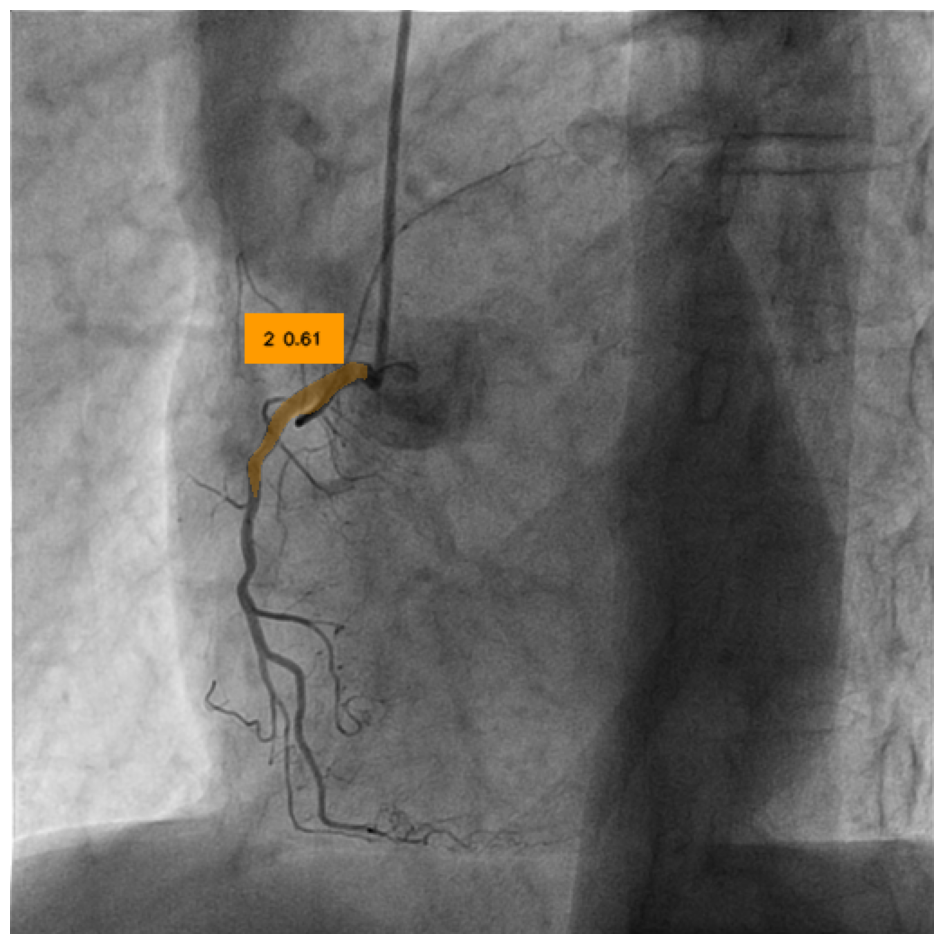

In [15]:
from rfdetr import RFDETRSegLarge
import supervision as sv
from PIL import Image

image = Image.open("/home/ives/rafal/rf-detr-seg/notebooks/notebooks/datasets/wum/1_I0468412.VIM.DCM.21.png").convert("RGB")

detections = model.predict(image, threshold=0.5)

# Klasy z modelu
model_classes = model.class_names  # {1: "class_name", ...}

# ── Parametry wizualizacji (lżejsze) ─────────────────────────────
text_scale = sv.calculate_optimal_text_scale(
    resolution_wh=image.size
) * 0.6   # 🔽 mniejszy tekst

thickness = sv.calculate_optimal_line_thickness(
    resolution_wh=image.size
) * 0.6   # 🔽 cieńsze obramowania

palette = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff",
    "#3399ff", "#ff66b2", "#ff8080"
])

# Maski – bardziej przezroczyste
mask_annotator = sv.MaskAnnotator(
    color=palette,
    opacity=0.3   # 🔽 większa przezroczystość
)

# Etykiety – małe i dyskretne
label_annotator = sv.LabelAnnotator(
    color=palette,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=1
)

# Etykiety predykcji
detections_labels = [
    f"{model_classes.get(class_id + 1, f'class_{class_id}')} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

# ── Wizualizacja ────────────────────────────────────────────────
result_image = image.copy()
result_image = mask_annotator.annotate(result_image, detections)
result_image = label_annotator.annotate(
    result_image,
    detections,
    detections_labels
)

sv.plot_image(
    image=result_image)



✓ Model classes: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '9a', 11: '10', 12: '10a', 13: '11', 14: '12', 15: '12a', 16: '13', 17: '14', 18: '14a', 19: '15', 20: '16', 21: '16a', 22: '16b', 23: '16c', 24: '12b', 25: '14b'}
✓ Dataset classes: ['segmentation_target']


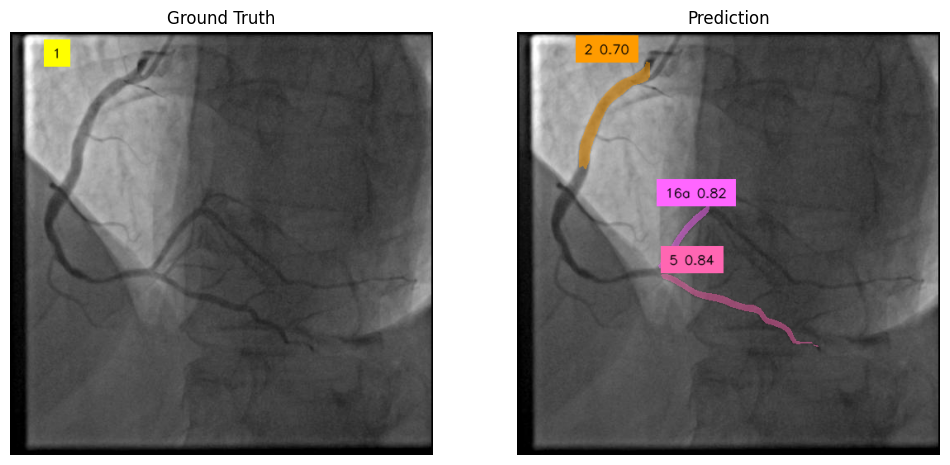

In [12]:
from rfdetr import RFDETRSegLarge
import supervision as sv
from PIL import Image

path, image, annotations = ds[50]
image = Image.open(path).convert('RGB')

detections = model.predict(image, threshold=0.5)

# 🔥 POBIERZ NAZWY KLAS Z MODELU (nie z datasetu)
model_classes = model.class_names  # To zwraca dict: {1: 'class_name', ...}

print(f"✓ Model classes: {model_classes}")
print(f"✓ Dataset classes: {ds.classes}")

# Parametry wizualizacji
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080"
])

# Annotatory dla segmentacji
mask_annotator = sv.MaskAnnotator(color=color, opacity=0.5)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale
)

# ✅ UŻYJ NAZW KLAS Z MODELU
annotations_labels = [
    model_classes.get(class_id + 1, ds.classes[class_id] if class_id < len(ds.classes) else f"class_{class_id}")
    for class_id in annotations.class_id
]

detections_labels = [
    f"{model_classes.get(class_id + 1, f'class_{class_id}')} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

# Wizualizacja
annotation_image = image.copy()
annotation_image = mask_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = mask_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(
    images=[annotation_image, detections_image],
    grid_size=(1, 2),
    titles=["Ground Truth", "Prediction"]
)

In [ ]:
# 🎨 WIZUALIZACJA Z MASKAMI - 28 KLAS Z RÓŻNYMI KOLORAMI
from rfdetr import RFDETRSegLarge
import supervision as sv
from PIL import Image

# ds = sv.DetectionDataset.from_coco(
#     images_directory_path=f"./arcade_coco_dataset_seg/test",
#     annotations_path=f"./arcade_coco_dataset_seg/test/_annotations.coco.json",
# )

# Wybierz próbkę
sample_idx = 4
path, _, annotations = ds[sample_idx]
image = Image.open(path).convert('RGB')

detections = model.predict(image, threshold=0.5)

# 🔍 DIAGNOSTYKA
print(f"✓ Annotations has mask: {annotations.mask is not None}")
print(f"✓ Detections has mask: {detections.mask is not None}")
print(f"✓ GT class_ids: {annotations.class_id}")
print(f"✓ Pred class_ids: {detections.class_id}")

# 🔥 POBIERZ NAZWY KLAS Z MODELU
model_classes = model.class_names  # Dict: {1: 'class_name', ...}
print(f"✓ Model classes: {model_classes}")
print(f"✓ Dataset classes ({len(ds.classes)}): {ds.classes}")

# Parametry wizualizacji
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

# ✅ PALETA 26 KOLORÓW - różne odcienie dla każdej klasy tętnic wieńcowych
COLOR_PALETTE_26 = sv.ColorPalette.from_hex([
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF8000",  # 0-6
    "#8000FF", "#00FF80", "#FF0080", "#80FF00", "#0080FF", "#FF8080", "#80FF80",  # 7-13
    "#8080FF", "#FFFF80", "#FF80FF", "#80FFFF", "#C00000", "#00C000", "#0000C0",  # 14-20
    "#C0C000", "#C000C0", "#00C0C0", "#FFA500", "#A500FF"                          # 21-25
])

# ✅ Annotatory z paletą kolorów + COLOR_LOOKUP.CLASS (kolor na podstawie class_id!)
mask_annotator = sv.MaskAnnotator(
    color=COLOR_PALETTE_26, 
    opacity=0.5,
    color_lookup=sv.ColorLookup.CLASS  # 🔑 KLUCZOWE: kolor na podstawie class_id
)
label_annotator = sv.LabelAnnotator(
    color=COLOR_PALETTE_26,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    color_lookup=sv.ColorLookup.CLASS  # 🔑 KLUCZOWE: kolor na podstawie class_id
)

# ✅ UŻYJ NAZW KLAS Z MODELU (mapowanie class_id -> nazwa)
# Teraz zarówno GT jak i model używają 1-indexed class_id (1-26)
annotations_labels = [
    model_classes.get(class_id, f"class_{class_id}")
    for class_id in annotations.class_id
]

detections_labels = [
    f"{model_classes.get(class_id, f'class_{class_id}')} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

# 🎨 WIZUALIZACJA GROUND TRUTH
annotation_image = image.copy()
if annotations.mask is not None:
    annotation_image = mask_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

# 🎨 WIZUALIZACJA PREDIKCJI
detections_image = image.copy()
if detections.mask is not None:
    detections_image = mask_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(
    images=[annotation_image, detections_image],
    grid_size=(1, 2),
    titles=["Ground Truth", "Prediction"]
)

In [ ]:
import supervision as sv
from tqdm import tqdm
from PIL import Image
from 
targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    # Załaduj obraz
    image = Image.open(path)

    # ✅ KONWERTUJ DO RGB (nawet jeśli już jest RGB, to nie szkodzi)
    image = image.convert('RGB')

    # Predykcja
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

## 📊 Ewaluacja Segmentacji - Dice/IoU na zbiorze testowym

In [11]:
import numpy as np
import supervision as sv
from PIL import Image
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass, field
from collections import defaultdict


@dataclass
class SegmentationMetrics:
    """Container for segmentation evaluation metrics."""
    dice_scores: List[float] = field(default_factory=list)
    iou_scores: List[float] = field(default_factory=list)
    per_class_dice: Dict[int, List[float]] = field(default_factory=lambda: defaultdict(list))
    per_class_iou: Dict[int, List[float]] = field(default_factory=lambda: defaultdict(list))
    
    @property
    def mean_dice(self) -> float:
        return np.mean(self.dice_scores) if self.dice_scores else 0.0
    
    @property
    def mean_iou(self) -> float:
        return np.mean(self.iou_scores) if self.iou_scores else 0.0
    
    @property
    def std_dice(self) -> float:
        return np.std(self.dice_scores) if self.dice_scores else 0.0
    
    @property
    def std_iou(self) -> float:
        return np.std(self.iou_scores) if self.iou_scores else 0.0


def compute_mask_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute IoU (Intersection over Union) between two binary masks.
    
    Args:
        mask1: First binary mask (H, W) or (N, H, W)
        mask2: Second binary mask (H, W) or (N, H, W)
    
    Returns:
        IoU score [0, 1]
    """
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    return float(intersection / union)


def compute_mask_dice(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute Dice coefficient between two binary masks.
    
    Dice = 2 * |A ∩ B| / (|A| + |B|)
    
    Args:
        mask1: First binary mask (H, W) or (N, H, W)
        mask2: Second binary mask (H, W) or (N, H, W)
    
    Returns:
        Dice score [0, 1]
    """
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    intersection = np.logical_and(mask1, mask2).sum()
    sum_masks = mask1.sum() + mask2.sum()
    
    if sum_masks == 0:
        return 1.0 if intersection == 0 else 0.0
    
    return float(2.0 * intersection / sum_masks)


def merge_masks_by_class(
    masks: np.ndarray, 
    class_ids: np.ndarray, 
    num_classes: int = 26
) -> Dict[int, np.ndarray]:
    """
    Merge instance masks into per-class semantic masks.
    
    Args:
        masks: Instance masks (N, H, W)
        class_ids: Class ID for each mask (N,)
        num_classes: Total number of classes
    
    Returns:
        Dictionary mapping class_id -> merged binary mask
    """
    if masks is None or len(masks) == 0:
        return {}
    
    h, w = masks.shape[1], masks.shape[2]
    class_masks = {}
    
    for class_id in np.unique(class_ids):
        class_mask = np.zeros((h, w), dtype=bool)
        for mask, cid in zip(masks, class_ids):
            if cid == class_id:
                class_mask = np.logical_or(class_mask, mask)
        class_masks[int(class_id)] = class_mask
    
    return class_masks


def evaluate_segmentation_on_dataset(
    model,
    dataset: Union['COCOSegmentationDataset', sv.DetectionDataset],
    threshold: float = 0.5,
    iou_matching_threshold: float = 0.5,
    num_classes: int = 26,
    verbose: bool = True,
) -> SegmentationMetrics:
    """
    Evaluate segmentation model on entire dataset.
    
    ⚠️ WAŻNE: Używaj COCOSegmentationDataset (zdefiniowany wcześniej w notebooku),
    NIE sv.DetectionDataset.from_coco() - bo ten NIE ładuje masek!
    
    Computes Dice and IoU metrics:
    1. Per-image global mask (all instances merged)
    2. Per-class masks (instances of same class merged)
    
    Args:
        model: RF-DETR model with predict() method
        dataset: COCOSegmentationDataset lub sv.DetectionDataset z maskami
        threshold: Detection confidence threshold
        iou_matching_threshold: IoU threshold for matching GT to predictions
        num_classes: Number of classes in dataset
        verbose: Print progress
    
    Returns:
        SegmentationMetrics with all computed scores
    """
    metrics = SegmentationMetrics()
    
    # Get class names from model if available
    class_names = getattr(model, 'class_names', {})
    
    iterator = tqdm(range(len(dataset)), desc="Evaluating") if verbose else range(len(dataset))
    
    skipped_no_masks = 0
    processed = 0
    
    for idx in iterator:
        # ✅ POPRAWKA: Obsłuż różne formaty zwracane przez dataset
        item = dataset[idx]
        
        # COCOSegmentationDataset zwraca: (path, None, detections)
        # sv.DetectionDataset zwraca: (path, image, detections)
        if len(item) == 3:
            path, _, gt_annotations = item
        else:
            path, gt_annotations = item[0], item[-1]
        
        # Załaduj obraz
        image = Image.open(path).convert('RGB')
        img_w, img_h = image.size
        
        # Get predictions
        pred_detections = model.predict(image, threshold=threshold)
        
        # ✅ POPRAWKA: Sprawdź czy gt_annotations to sv.Detections
        if isinstance(gt_annotations, sv.Detections):
            gt_masks = gt_annotations.mask
            gt_class_ids = gt_annotations.class_id
        else:
            # Jeśli to nie Detections, spróbuj wyciągnąć maski
            gt_masks = getattr(gt_annotations, 'mask', None)
            gt_class_ids = getattr(gt_annotations, 'class_id', None)
        
        pred_masks = pred_detections.mask if hasattr(pred_detections, 'mask') else None
        pred_class_ids = pred_detections.class_id if hasattr(pred_detections, 'class_id') else None
        
        # ✅ DEBUG: Sprawdź czy maski są dostępne
        if gt_masks is None or len(gt_masks) == 0:
            skipped_no_masks += 1
            if verbose and skipped_no_masks <= 3:
                print(f"⚠️ Image {idx} ({path.split('/')[-1]}): No GT masks!")
                print(f"   gt_annotations type: {type(gt_annotations)}")
                if hasattr(gt_annotations, '__dict__'):
                    print(f"   gt_annotations attrs: {list(gt_annotations.__dict__.keys())[:5]}")
            continue
        
        processed += 1
        
        # Get image dimensions from masks
        h, w = gt_masks.shape[1], gt_masks.shape[2]
        
        # === 1. GLOBAL MASK EVALUATION ===
        # Merge all GT masks into one
        gt_global = np.zeros((h, w), dtype=bool)
        for mask in gt_masks:
            gt_global = np.logical_or(gt_global, mask)
        
        # Merge all prediction masks into one
        pred_global = np.zeros((h, w), dtype=bool)
        if pred_masks is not None and len(pred_masks) > 0:
            for mask in pred_masks:
                pred_global = np.logical_or(pred_global, mask)
        
        # Compute global metrics
        global_dice = compute_mask_dice(gt_global, pred_global)
        global_iou = compute_mask_iou(gt_global, pred_global)
        
        metrics.dice_scores.append(global_dice)
        metrics.iou_scores.append(global_iou)
        
        # === 2. PER-CLASS EVALUATION ===
        if gt_class_ids is not None:
            gt_class_masks = merge_masks_by_class(gt_masks, gt_class_ids, num_classes)
        else:
            gt_class_masks = {0: gt_global}
        
        if pred_masks is not None and len(pred_masks) > 0 and pred_class_ids is not None:
            pred_class_masks = merge_masks_by_class(pred_masks, pred_class_ids, num_classes)
        else:
            pred_class_masks = {}
        
        # Compute per-class metrics
        all_classes = set(gt_class_masks.keys()) | set(pred_class_masks.keys())
        
        for class_id in all_classes:
            gt_mask = gt_class_masks.get(class_id, np.zeros((h, w), dtype=bool))
            pred_mask = pred_class_masks.get(class_id, np.zeros((h, w), dtype=bool))
            
            class_dice = compute_mask_dice(gt_mask, pred_mask)
            class_iou = compute_mask_iou(gt_mask, pred_mask)
            
            metrics.per_class_dice[class_id].append(class_dice)
            metrics.per_class_iou[class_id].append(class_iou)
    
    if verbose:
        print(f"\n✅ Evaluation complete:")
        print(f"   Processed: {processed} images")
        print(f"   Skipped (no masks): {skipped_no_masks} images")
        if skipped_no_masks > 0:
            print(f"\n⚠️ UWAGA: {skipped_no_masks} obrazów bez masek!")
            print(f"   Upewnij się, że używasz COCOSegmentationDataset (nie sv.DetectionDataset.from_coco)!")
    
    return metrics


def print_evaluation_report(
    metrics: SegmentationMetrics,
    class_names: Optional[Dict[int, str]] = None,
    show_per_class: bool = True,
) -> None:
    """
    Print formatted evaluation report.
    
    Args:
        metrics: Computed SegmentationMetrics
        class_names: Optional mapping class_id -> name
        show_per_class: Whether to show per-class breakdown
    """
    print("\n" + "=" * 60)
    print("📊 SEGMENTATION EVALUATION REPORT")
    print("=" * 60)
    
    print(f"\n🎯 GLOBAL METRICS (all classes merged per image)")
    print(f"   Images evaluated: {len(metrics.dice_scores)}")
    print(f"   Mean Dice:  {metrics.mean_dice:.4f} ± {metrics.std_dice:.4f}")
    print(f"   Mean IoU:   {metrics.mean_iou:.4f} ± {metrics.std_iou:.4f}")
    
    if show_per_class and metrics.per_class_dice:
        print(f"\n📈 PER-CLASS METRICS")
        print("-" * 60)
        print(f"{'Class':<30} {'Dice':>10} {'IoU':>10} {'Samples':>10}")
        print("-" * 60)
        
        # Sort by class_id
        sorted_classes = sorted(metrics.per_class_dice.keys())
        
        class_dice_means = []
        class_iou_means = []
        
        for class_id in sorted_classes:
            dice_scores = metrics.per_class_dice[class_id]
            iou_scores = metrics.per_class_iou[class_id]
            
            mean_dice = np.mean(dice_scores)
            mean_iou = np.mean(iou_scores)
            n_samples = len(dice_scores)
            
            class_dice_means.append(mean_dice)
            class_iou_means.append(mean_iou)
            
            # Get class name
            if class_names and class_id in class_names:
                name = f"{class_id}: {class_names[class_id]}"
            else:
                name = f"Class {class_id}"
            
            print(f"{name:<30} {mean_dice:>10.4f} {mean_iou:>10.4f} {n_samples:>10}")
        
        print("-" * 60)
        print(f"{'MACRO AVERAGE':<30} {np.mean(class_dice_means):>10.4f} {np.mean(class_iou_means):>10.4f}")
    
    print("\n" + "=" * 60)


def plot_per_class_metrics(
    metrics: SegmentationMetrics,
    class_names: Optional[Dict[int, str]] = None,
    figsize: Tuple[int, int] = (14, 6),
) -> None:
    """
    Plot per-class Dice and IoU scores as bar charts.
    
    Args:
        metrics: Computed SegmentationMetrics
        class_names: Optional mapping class_id -> name
        figsize: Figure size
    """
    import matplotlib.pyplot as plt
    
    sorted_classes = sorted(metrics.per_class_dice.keys())
    
    dice_means = [np.mean(metrics.per_class_dice[c]) for c in sorted_classes]
    iou_means = [np.mean(metrics.per_class_iou[c]) for c in sorted_classes]
    
    # Get class labels
    if class_names:
        labels = [class_names.get(c, f"Class {c}") for c in sorted_classes]
    else:
        labels = [f"Class {c}" for c in sorted_classes]
    
    x = np.arange(len(sorted_classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=figsize)
    bars1 = ax.bar(x - width/2, dice_means, width, label='Dice', color='steelblue')
    bars2 = ax.bar(x + width/2, iou_means, width, label='IoU', color='coral')
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Segmentation Metrics (Dice & IoU)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.0)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=np.mean(dice_means), color='steelblue', linestyle=':', alpha=0.7, label=f'Mean Dice={np.mean(dice_means):.3f}')
    ax.axhline(y=np.mean(iou_means), color='coral', linestyle=':', alpha=0.7, label=f'Mean IoU={np.mean(iou_means):.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Summary:")
    print(f"   Macro Dice: {np.mean(dice_means):.4f}")
    print(f"   Macro IoU:  {np.mean(iou_means):.4f}")
    print(f"   Best class (Dice): {labels[np.argmax(dice_means)]} = {max(dice_means):.4f}")
    print(f"   Worst class (Dice): {labels[np.argmin(dice_means)]} = {min(dice_means):.4f}")

### ⚠️ Uwaga o metrykach dla niezbalansowanych zbiorów

Przy niezbalansowanym zbiorze (jak ARCADE z różną częstością naczyń) ważny jest wybór metody agregacji:

| Metryka | Opis | Kiedy używać |
|---------|------|--------------|
| **Macro Dice/IoU** | Średnia po klasach (każda klasa = 1 głos) | Gdy zależy nam na rzadkich klasach |
| **Weighted Dice/IoU** | Ważona liczbą instancji klasy | Bardziej realistyczna ocena |
| **Frequency-weighted IoU** | Ważona liczbą pikseli klasy | Gdy duże obiekty są ważniejsze |
| **Instance-level** | Średnia po pojedynczych instancjach | Gdy każda instancja równie ważna |

**Problem z obecnym podejściem:**
- Klasa z 5 instancji ma taki sam wpływ jak klasa z 500 instancji
- Małe naczynia (np. gałęzie) mają taki sam wpływ jak duże (np. LAD główny)

In [1]:
import numpy as np
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass, field
from collections import defaultdict


@dataclass 
class BalancedSegmentationMetrics:
    """
    Extended metrics for imbalanced segmentation datasets.
    
    Includes multiple aggregation methods:
    - Macro: equal weight per class
    - Weighted: weighted by class frequency (instance count)
    - Frequency-weighted: weighted by pixel count
    - Instance-level: per-instance metrics
    """
    # Per-class aggregated
    per_class_dice: Dict[int, List[float]] = field(default_factory=lambda: defaultdict(list))
    per_class_iou: Dict[int, List[float]] = field(default_factory=lambda: defaultdict(list))
    per_class_pixel_counts: Dict[int, List[int]] = field(default_factory=lambda: defaultdict(list))
    per_class_instance_counts: Dict[int, int] = field(default_factory=lambda: defaultdict(int))
    
    # Instance-level (każda pojedyncza maska)
    instance_dice: List[float] = field(default_factory=list)
    instance_iou: List[float] = field(default_factory=list)
    instance_class_ids: List[int] = field(default_factory=list)
    instance_pixel_counts: List[int] = field(default_factory=list)
    
    # Global (wszystkie maski merged per image)
    global_dice: List[float] = field(default_factory=list)
    global_iou: List[float] = field(default_factory=list)
    
    # === MACRO METRICS (każda klasa = 1 głos) ===
    @property
    def macro_dice(self) -> float:
        """Mean Dice per class (unweighted)."""
        class_means = [np.mean(scores) for scores in self.per_class_dice.values() if scores]
        return np.mean(class_means) if class_means else 0.0
    
    @property
    def macro_iou(self) -> float:
        """Mean IoU per class (unweighted)."""
        class_means = [np.mean(scores) for scores in self.per_class_iou.values() if scores]
        return np.mean(class_means) if class_means else 0.0
    
    # === WEIGHTED METRICS (ważone liczbą instancji) ===
    @property
    def weighted_dice(self) -> float:
        """Dice weighted by class instance frequency."""
        total_instances = sum(self.per_class_instance_counts.values())
        if total_instances == 0:
            return 0.0
        
        weighted_sum = 0.0
        for class_id, scores in self.per_class_dice.items():
            weight = self.per_class_instance_counts[class_id] / total_instances
            weighted_sum += weight * np.mean(scores)
        return weighted_sum
    
    @property
    def weighted_iou(self) -> float:
        """IoU weighted by class instance frequency."""
        total_instances = sum(self.per_class_instance_counts.values())
        if total_instances == 0:
            return 0.0
        
        weighted_sum = 0.0
        for class_id, scores in self.per_class_iou.items():
            weight = self.per_class_instance_counts[class_id] / total_instances
            weighted_sum += weight * np.mean(scores)
        return weighted_sum
    
    # === FREQUENCY-WEIGHTED (ważone liczbą pikseli) ===
    @property
    def frequency_weighted_iou(self) -> float:
        """IoU weighted by total pixel count per class."""
        total_pixels = sum(sum(counts) for counts in self.per_class_pixel_counts.values())
        if total_pixels == 0:
            return 0.0
        
        weighted_sum = 0.0
        for class_id, scores in self.per_class_iou.items():
            class_pixels = sum(self.per_class_pixel_counts.get(class_id, [0]))
            weight = class_pixels / total_pixels
            weighted_sum += weight * np.mean(scores)
        return weighted_sum
    
    @property
    def frequency_weighted_dice(self) -> float:
        """Dice weighted by total pixel count per class."""
        total_pixels = sum(sum(counts) for counts in self.per_class_pixel_counts.values())
        if total_pixels == 0:
            return 0.0
        
        weighted_sum = 0.0
        for class_id, scores in self.per_class_dice.items():
            class_pixels = sum(self.per_class_pixel_counts.get(class_id, [0]))
            weight = class_pixels / total_pixels
            weighted_sum += weight * np.mean(scores)
        return weighted_sum
    
    # === INSTANCE-LEVEL (każda maska = 1 głos) ===
    @property
    def instance_mean_dice(self) -> float:
        """Mean Dice across all instances."""
        return np.mean(self.instance_dice) if self.instance_dice else 0.0
    
    @property
    def instance_mean_iou(self) -> float:
        """Mean IoU across all instances."""
        return np.mean(self.instance_iou) if self.instance_iou else 0.0
    
    # === GLOBAL (merged masks per image) ===
    @property
    def mean_global_dice(self) -> float:
        return np.mean(self.global_dice) if self.global_dice else 0.0
    
    @property
    def mean_global_iou(self) -> float:
        return np.mean(self.global_iou) if self.global_iou else 0.0


def evaluate_with_balanced_metrics(
    model,
    dataset,
    threshold: float = 0.5,
    num_classes: int = 26,
    class_names: Optional[Dict[int, str]] = None,
    verbose: bool = True,
) -> BalancedSegmentationMetrics:
    """
    Evaluate segmentation with multiple aggregation methods for imbalanced data.
    
    Args:
        model: RF-DETR model
        dataset: COCOSegmentationDataset
        threshold: Detection confidence threshold
        num_classes: Number of classes
        class_names: Optional class name mapping
        verbose: Print progress
    
    Returns:
        BalancedSegmentationMetrics with all aggregation methods
    """
    from PIL import Image
    from tqdm import tqdm
    
    metrics = BalancedSegmentationMetrics()
    
    iterator = tqdm(range(len(dataset)), desc="Evaluating") if verbose else range(len(dataset))
    
    for idx in iterator:
        item = dataset[idx]
        path, _, gt_annotations = item if len(item) == 3 else (item[0], None, item[-1])
        
        image = Image.open(path).convert('RGB')
        pred_detections = model.predict(image, threshold=threshold)
        
        gt_masks = gt_annotations.mask
        gt_class_ids = gt_annotations.class_id
        pred_masks = pred_detections.mask if hasattr(pred_detections, 'mask') else None
        pred_class_ids = pred_detections.class_id if hasattr(pred_detections, 'class_id') else None
        
        if gt_masks is None or len(gt_masks) == 0:
            continue
        
        h, w = gt_masks.shape[1], gt_masks.shape[2]
        
        # === GLOBAL METRICS ===
        gt_global = np.zeros((h, w), dtype=bool)
        for mask in gt_masks:
            gt_global = np.logical_or(gt_global, mask)
        
        pred_global = np.zeros((h, w), dtype=bool)
        if pred_masks is not None and len(pred_masks) > 0:
            for mask in pred_masks:
                pred_global = np.logical_or(pred_global, mask)
        
        metrics.global_dice.append(compute_mask_dice(gt_global, pred_global))
        metrics.global_iou.append(compute_mask_iou(gt_global, pred_global))
        
        # === INSTANCE-LEVEL MATCHING ===
        # Dla każdej GT instancji, znajdź najlepiej pasującą predykcję
        for gt_idx, (gt_mask, gt_class) in enumerate(zip(gt_masks, gt_class_ids)):
            gt_class = int(gt_class)
            gt_pixels = gt_mask.sum()
            
            # Znajdź matching prediction (sama klasa, najlepszy IoU)
            best_iou = 0.0
            best_dice = 0.0
            
            if pred_masks is not None and len(pred_masks) > 0:
                for pred_idx, (pred_mask, pred_class) in enumerate(zip(pred_masks, pred_class_ids)):
                    if int(pred_class) == gt_class:
                        iou = compute_mask_iou(gt_mask, pred_mask)
                        if iou > best_iou:
                            best_iou = iou
                            best_dice = compute_mask_dice(gt_mask, pred_mask)
            
            # Record instance metrics
            metrics.instance_dice.append(best_dice)
            metrics.instance_iou.append(best_iou)
            metrics.instance_class_ids.append(gt_class)
            metrics.instance_pixel_counts.append(int(gt_pixels))
            
            # Record per-class metrics
            metrics.per_class_dice[gt_class].append(best_dice)
            metrics.per_class_iou[gt_class].append(best_iou)
            metrics.per_class_pixel_counts[gt_class].append(int(gt_pixels))
            metrics.per_class_instance_counts[gt_class] += 1
    
    return metrics


def print_balanced_metrics_report(
    metrics: BalancedSegmentationMetrics,
    class_names: Optional[Dict[int, str]] = None,
    show_per_class: bool = True,
) -> None:
    """
    Print comprehensive report with all aggregation methods.
    """
    print("\n" + "=" * 80)
    print("📊 BALANCED SEGMENTATION METRICS REPORT")
    print("=" * 80)
    
    print("\n🎯 AGGREGATION COMPARISON:")
    print("-" * 60)
    print(f"{'Aggregation Method':<30} {'Dice':>12} {'IoU':>12}")
    print("-" * 60)
    print(f"{'Macro (per-class equal)':<30} {metrics.macro_dice:>12.4f} {metrics.macro_iou:>12.4f}")
    print(f"{'Weighted (by instance count)':<30} {metrics.weighted_dice:>12.4f} {metrics.weighted_iou:>12.4f}")
    print(f"{'Freq-weighted (by pixels)':<30} {metrics.frequency_weighted_dice:>12.4f} {metrics.frequency_weighted_iou:>12.4f}")
    print(f"{'Instance-level (per mask)':<30} {metrics.instance_mean_dice:>12.4f} {metrics.instance_mean_iou:>12.4f}")
    print(f"{'Global (merged per image)':<30} {metrics.mean_global_dice:>12.4f} {metrics.mean_global_iou:>12.4f}")
    print("-" * 60)
    
    # Interpretacja
    diff = abs(metrics.macro_dice - metrics.weighted_dice)
    if diff > 0.05:
        print(f"\n⚠️ UWAGA: Różnica między Macro a Weighted = {diff:.4f}")
        if metrics.macro_dice < metrics.weighted_dice:
            print("   → Model radzi sobie GORZEJ z rzadkimi klasami (małe naczynia)")
        else:
            print("   → Model radzi sobie LEPIEJ z rzadkimi klasami niż z częstymi")
    
    if show_per_class:
        print(f"\n📈 PER-CLASS BREAKDOWN:")
        print("-" * 80)
        print(f"{'Class':<25} {'Instances':>10} {'Pixels':>12} {'Dice':>10} {'IoU':>10} {'Weight':>10}")
        print("-" * 80)
        
        total_instances = sum(metrics.per_class_instance_counts.values())
        sorted_classes = sorted(metrics.per_class_dice.keys())
        
        for class_id in sorted_classes:
            n_inst = metrics.per_class_instance_counts[class_id]
            n_pixels = sum(metrics.per_class_pixel_counts.get(class_id, [0]))
            mean_dice = np.mean(metrics.per_class_dice[class_id])
            mean_iou = np.mean(metrics.per_class_iou[class_id])
            weight = n_inst / total_instances if total_instances > 0 else 0
            
            name = class_names.get(class_id, f"Class {class_id}") if class_names else f"Class {class_id}"
            name = name[:24]  # Truncate
            
            print(f"{name:<25} {n_inst:>10} {n_pixels:>12} {mean_dice:>10.4f} {mean_iou:>10.4f} {weight:>9.2%}")
        
        print("-" * 80)
    
    print("\n📋 ZALECENIA:")
    print("   • Macro - raportuj gdy ważne są WSZYSTKIE klasy (w tym rzadkie)")
    print("   • Weighted - raportuj jako główną metrykę (realistyczna ocena)")
    print("   • Freq-weighted - gdy duże naczynia są ważniejsze klinicznie")
    print("   • Instance-level - gdy każda pojedyncza detekcja jest istotna")
    print("=" * 80)


def plot_class_imbalance_analysis(
    metrics: BalancedSegmentationMetrics,
    class_names: Optional[Dict[int, str]] = None,
    figsize: Tuple[int, int] = (16, 10)
) -> None:
    """
    Visualize relationship between class frequency and performance.
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Data preparation
    classes = sorted(metrics.per_class_dice.keys())
    dice_means = [np.mean(metrics.per_class_dice[c]) for c in classes]
    iou_means = [np.mean(metrics.per_class_iou[c]) for c in classes]
    instance_counts = [metrics.per_class_instance_counts[c] for c in classes]
    pixel_counts = [sum(metrics.per_class_pixel_counts.get(c, [0])) for c in classes]
    
    labels = [class_names.get(c, f"C{c}") if class_names else f"C{c}" for c in classes]
    labels = [l[:15] for l in labels]  # Shorten
    
    # === 1. Dice vs Instance Count (scatter) ===
    ax1 = axes[0, 0]
    scatter = ax1.scatter(instance_counts, dice_means, c=classes, cmap='tab20', s=100, alpha=0.7)
    ax1.set_xlabel('Instance Count')
    ax1.set_ylabel('Mean Dice')
    ax1.set_title('Dice Score vs Class Frequency')
    
    # Add labels for extreme points
    for i, (x, y, label) in enumerate(zip(instance_counts, dice_means, labels)):
        if x == max(instance_counts) or x == min(instance_counts) or y == max(dice_means) or y == min(dice_means):
            ax1.annotate(label, (x, y), fontsize=8, alpha=0.8)
    
    # Trend line
    z = np.polyfit(instance_counts, dice_means, 1)
    p = np.poly1d(z)
    ax1.plot(sorted(instance_counts), p(sorted(instance_counts)), "r--", alpha=0.5, label=f'Trend')
    ax1.legend()
    
    # === 2. Dice distribution per class (boxplot) ===
    ax2 = axes[0, 1]
    box_data = [metrics.per_class_dice[c] for c in classes]
    bp = ax2.boxplot(box_data, labels=labels, vert=True, patch_artist=True)
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Dice Score')
    ax2.set_title('Dice Distribution per Class')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=metrics.weighted_dice, color='red', linestyle='--', label=f'Weighted mean: {metrics.weighted_dice:.3f}')
    ax2.axhline(y=metrics.macro_dice, color='blue', linestyle=':', label=f'Macro mean: {metrics.macro_dice:.3f}')
    ax2.legend()
    
    # === 3. Class weights distribution ===
    ax3 = axes[1, 0]
    total_inst = sum(instance_counts)
    weights = [c/total_inst for c in instance_counts]
    bars = ax3.bar(range(len(classes)), weights, color='steelblue', alpha=0.7)
    ax3.set_xlabel('Class')
    ax3.set_ylabel('Weight (instance-based)')
    ax3.set_title('Class Weights in Dataset')
    ax3.set_xticks(range(len(classes)))
    ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax3.axhline(y=1/len(classes), color='red', linestyle='--', label=f'Equal weight: {1/len(classes):.3f}')
    ax3.legend()
    
    # === 4. Macro vs Weighted comparison ===
    ax4 = axes[1, 1]
    metrics_names = ['Macro\nDice', 'Weighted\nDice', 'Freq-wt\nDice', 'Instance\nDice', 'Global\nDice']
    values = [
        metrics.macro_dice,
        metrics.weighted_dice,
        metrics.frequency_weighted_dice,
        metrics.instance_mean_dice,
        metrics.mean_global_dice
    ]
    colors = ['steelblue', 'coral', 'green', 'purple', 'gold']
    bars = ax4.bar(metrics_names, values, color=colors, alpha=0.7)
    ax4.set_ylabel('Dice Score')
    ax4.set_title('Comparison of Aggregation Methods')
    ax4.set_ylim(0, 1)
    
    # Add values on bars
    for bar, val in zip(bars, values):
        ax4.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
                ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis
    corr = np.corrcoef(instance_counts, dice_means)[0, 1]
    print(f"\n📈 Korelacja: częstość klasy vs Dice = {corr:.3f}")
    if corr > 0.3:
        print("   → Model działa LEPIEJ na częstszych klasach (bias do dużych naczyń)")
    elif corr < -0.3:
        print("   → Model działa LEPIEJ na rzadszych klasach (zaskakujące!)")
    else:
        print("   → Brak wyraźnej zależności między częstością a jakością")

In [2]:
# Ewaluacja z balanced metrics
# Używamy wcześniej załadowanych datasetów

print("🔄 Computing balanced metrics on validation set...")

# Ewaluacja walidacyjna
balanced_val_metrics = evaluate_with_balanced_metrics(
    model=model,
    dataset=val_dataset,  # COCOSegmentationDataset
    threshold=0.5,
    class_names=class_names,
    verbose=True
)

# Raport z porównaniem wszystkich metod agregacji
print_balanced_metrics_report(balanced_val_metrics, class_names=class_names)

# Wizualizacja relacji między częstością klasy a jakością predykcji
plot_class_imbalance_analysis(balanced_val_metrics, class_names=class_names)

🔄 Computing balanced metrics on validation set...


NameError: name 'model' is not defined

In [12]:
# ============================================================================
# 🚀 URUCHOM EWALUACJĘ
# ============================================================================
# ⚠️ WAŻNE: Używaj COCOSegmentationDataset (zdefiniowany wcześniej w notebooku),
#           NIE sv.DetectionDataset.from_coco() - bo NIE ładuje masek!
# ============================================================================

# ✅ POPRAWNIE - użyj COCOSegmentationDataset z komórki 18
ds_eval = COCOSegmentationDataset(
    images_dir="./arcade_coco_detection2/test",
    annotations_path="./arcade_coco_detection2/test/_annotations.coco.json"
)

# ❌ ŹLE - sv.DetectionDataset.from_coco NIE ładuje masek!
# ds_eval = sv.DetectionDataset.from_coco(
#     images_directory_path="./arcade_coco_dataset_seg/test",
#     annotations_path="./arcade_coco_dataset_seg/test/_annotations.coco.json"
# )

# Sprawdź czy maski są załadowane
print("🔍 Sprawdzanie datasetu...")
path, _, annotations = ds_eval[0]
print(f"   Pierwszy obraz: {path.split('/')[-1]}")
print(f"   Typ annotations: {type(annotations)}")
print(f"   Ma maski: {annotations.mask is not None}")
if annotations.mask is not None:
    print(f"   Kształt masek: {annotations.mask.shape}")
    print(f"   Class IDs: {annotations.class_id}")
else:
    print("❌ BŁĄD: Brak masek! Upewnij się, że używasz COCOSegmentationDataset!")

# Uruchom ewaluację
print("\n" + "=" * 60)
print("🎯 EWALUACJA SEGMENTACJI")
print("=" * 60)

metrics = evaluate_segmentation_on_dataset(
    model=model,
    dataset=ds_eval,
    threshold=0.5,
    num_classes=26,
    verbose=True
)

# Wyświetl raport
print_evaluation_report(
    metrics,
    class_names=model.class_names if hasattr(model, 'class_names') else None,
    show_per_class=True
)

# Wykres per-class
plot_per_class_metrics(
    metrics,
    class_names=model.class_names if hasattr(model, 'class_names') else None
)

✓ Loaded 300 images with segmentation masks
✓ Categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '9a', 11: '10', 12: '10a', 13: '11', 14: '12', 15: '12a', 16: '13', 17: '14', 18: '14a', 19: '15', 20: '16', 21: '16a', 22: '16b', 23: '16c', 24: '12b', 25: '14b'}
🔍 Sprawdzanie datasetu...
   Pierwszy obraz: 1.png
   Typ annotations: <class 'supervision.detection.core.Detections'>
   Ma maski: True
   Kształt masek: (6, 512, 512)
   Class IDs: [18  5 17 25 13 16]

🎯 EWALUACJA SEGMENTACJI


NameError: name 'model' is not defined

## 📊 Analiza statystyk datasetu ARCADE

Sprawdź rozkład klas w zbiorze danych - ile razy występuje każda klasa (naczynia wieńcowe).

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Union, Optional
from dataclasses import dataclass


@dataclass
class DatasetStatistics:
    """Container for dataset statistics."""
    class_counts: Dict[int, int]  # class_id -> total instances
    class_image_counts: Dict[int, int]  # class_id -> number of images containing class
    total_images: int
    total_instances: int
    instances_per_image: List[int]  # number of instances in each image
    class_names: Optional[Dict[int, str]] = None
    
    @property
    def mean_instances_per_image(self) -> float:
        return np.mean(self.instances_per_image) if self.instances_per_image else 0.0
    
    @property
    def std_instances_per_image(self) -> float:
        return np.std(self.instances_per_image) if self.instances_per_image else 0.0


def analyze_dataset_statistics(
    dataset: Union['COCOSegmentationDataset', 'sv.DetectionDataset'],
    class_names: Optional[Dict[int, str]] = None,
    verbose: bool = True
) -> DatasetStatistics:
    """
    Analyze class distribution in the dataset.
    
    Args:
        dataset: COCOSegmentationDataset or sv.DetectionDataset
        class_names: Optional mapping class_id -> name
        verbose: Print progress
    
    Returns:
        DatasetStatistics with computed statistics
    """
    class_counts = defaultdict(int)  # Total instances per class
    class_image_counts = defaultdict(int)  # Images containing each class
    instances_per_image = []
    
    if verbose:
        print(f"🔍 Analyzing dataset with {len(dataset)} images...")
    
    for idx in range(len(dataset)):
        item = dataset[idx]
        
        # Handle different dataset formats
        if len(item) == 3:
            path, _, annotations = item
        else:
            path, annotations = item[0], item[-1]
        
        # Get class IDs
        if hasattr(annotations, 'class_id') and annotations.class_id is not None:
            class_ids = annotations.class_id
        else:
            continue
        
        # Count instances in this image
        instances_per_image.append(len(class_ids))
        
        # Count per class
        unique_classes_in_image = set()
        for class_id in class_ids:
            class_counts[int(class_id)] += 1
            unique_classes_in_image.add(int(class_id))
        
        # Count images containing each class
        for class_id in unique_classes_in_image:
            class_image_counts[class_id] += 1
    
    stats = DatasetStatistics(
        class_counts=dict(class_counts),
        class_image_counts=dict(class_image_counts),
        total_images=len(dataset),
        total_instances=sum(class_counts.values()),
        instances_per_image=instances_per_image,
        class_names=class_names
    )
    
    return stats


def print_dataset_statistics(stats: DatasetStatistics) -> None:
    """
    Print formatted dataset statistics report.
    
    Args:
        stats: DatasetStatistics object
    """
    print("\n" + "=" * 80)
    print("📊 DATASET STATISTICS - ARCADE CORONARY ARTERIES")
    print("=" * 80)
    
    print(f"\n📈 GLOBAL STATISTICS:")
    print(f"   Total images:           {stats.total_images}")
    print(f"   Total instances:        {stats.total_instances}")
    print(f"   Instances per image:    {stats.mean_instances_per_image:.2f} ± {stats.std_instances_per_image:.2f}")
    print(f"   Min instances/image:    {min(stats.instances_per_image) if stats.instances_per_image else 0}")
    print(f"   Max instances/image:    {max(stats.instances_per_image) if stats.instances_per_image else 0}")
    print(f"   Unique classes:         {len(stats.class_counts)}")
    
    print(f"\n🫀 PER-CLASS STATISTICS (CORONARY ARTERIES):")
    print("-" * 80)
    print(f"{'Class':<35} {'Instances':>12} {'Images':>10} {'Avg/Image':>12} {'Coverage %':>12}")
    print("-" * 80)
    
    # Sort by class ID
    sorted_classes = sorted(stats.class_counts.keys())
    
    for class_id in sorted_classes:
        n_instances = stats.class_counts[class_id]
        n_images = stats.class_image_counts[class_id]
        avg_per_image = n_instances / n_images if n_images > 0 else 0
        coverage_pct = 100 * n_images / stats.total_images
        
        # Get class name
        if stats.class_names and class_id in stats.class_names:
            name = f"{class_id}: {stats.class_names[class_id]}"
        else:
            name = f"Class {class_id}"
        
        print(f"{name:<35} {n_instances:>12} {n_images:>10} {avg_per_image:>12.2f} {coverage_pct:>11.1f}%")
    
    print("-" * 80)
    print(f"{'TOTAL':<35} {stats.total_instances:>12} {stats.total_images:>10}")
    print("=" * 80)


def plot_dataset_statistics(
    stats: DatasetStatistics,
    figsize: tuple = (16, 10),
    top_n: Optional[int] = None
) -> None:
    """
    Visualize dataset statistics with multiple plots.
    
    Args:
        stats: DatasetStatistics object
        figsize: Figure size
        top_n: Show only top N most frequent classes (None = all)
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    sorted_classes = sorted(stats.class_counts.keys(), 
                           key=lambda x: stats.class_counts[x], 
                           reverse=True)
    
    if top_n:
        sorted_classes = sorted_classes[:top_n]
    
    # Get class labels
    if stats.class_names:
        labels = [stats.class_names.get(c, f"Class {c}") for c in sorted_classes]
    else:
        labels = [f"Class {c}" for c in sorted_classes]
    
    # Shorten labels if too long
    labels = [l[:25] + '...' if len(l) > 25 else l for l in labels]
    
    instances = [stats.class_counts[c] for c in sorted_classes]
    image_counts = [stats.class_image_counts[c] for c in sorted_classes]
    coverage = [100 * stats.class_image_counts[c] / stats.total_images for c in sorted_classes]
    
    # === 1. Instances per class ===
    ax1 = axes[0, 0]
    bars = ax1.barh(range(len(sorted_classes)), instances, color='steelblue')
    ax1.set_yticks(range(len(sorted_classes)))
    ax1.set_yticklabels(labels, fontsize=9)
    ax1.set_xlabel('Number of Instances')
    ax1.set_title('Instances per Class (Coronary Arteries)')
    ax1.invert_yaxis()
    
    # Add values on bars
    for i, (bar, val) in enumerate(zip(bars, instances)):
        ax1.text(val, i, f' {val}', va='center', fontsize=8)
    
    # === 2. Image coverage ===
    ax2 = axes[0, 1]
    bars = ax2.barh(range(len(sorted_classes)), coverage, color='coral')
    ax2.set_yticks(range(len(sorted_classes)))
    ax2.set_yticklabels(labels, fontsize=9)
    ax2.set_xlabel('Coverage (%)')
    ax2.set_title('Image Coverage per Class')
    ax2.set_xlim(0, 100)
    ax2.invert_yaxis()
    
    # Add values
    for i, (bar, val) in enumerate(zip(bars, coverage)):
        ax2.text(val, i, f' {val:.1f}%', va='center', fontsize=8)
    
    # === 3. Instances per image distribution ===
    ax3 = axes[1, 0]
    ax3.hist(stats.instances_per_image, bins=30, color='green', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Instances per Image')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Instances per Image')
    ax3.axvline(stats.mean_instances_per_image, color='red', linestyle='--', 
                label=f'Mean: {stats.mean_instances_per_image:.2f}')
    ax3.legend()
    
    # === 4. Class balance pie chart (top classes) ===
    ax4 = axes[1, 1]
    top_10_classes = sorted_classes[:10]
    top_10_instances = [stats.class_counts[c] for c in top_10_classes]
    top_10_labels = [stats.class_names.get(c, f"Class {c}") if stats.class_names else f"Class {c}" 
                     for c in top_10_classes]
    
    # Shorten labels for pie
    top_10_labels = [l[:20] + '...' if len(l) > 20 else l for l in top_10_labels]
    
    # If there are more classes, add "Others"
    if len(sorted_classes) > 10:
        others = sum(stats.class_counts[c] for c in sorted_classes[10:])
        top_10_instances.append(others)
        top_10_labels.append(f'Others ({len(sorted_classes) - 10} classes)')
    
    colors = plt.cm.Set3(range(len(top_10_instances)))
    wedges, texts, autotexts = ax4.pie(
        top_10_instances, 
        labels=top_10_labels,
        autopct='%1.1f%%',
        colors=colors,
        textprops={'fontsize': 8}
    )
    ax4.set_title('Top 10 Classes by Instance Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📊 Visualization Summary:")
    print(f"   Most frequent class:  {labels[0]} ({instances[0]} instances)")
    print(f"   Least frequent class: {labels[-1]} ({instances[-1]} instances)")
    print(f"   Highest coverage:     {labels[np.argmax(coverage)]} ({max(coverage):.1f}%)")
    print(f"   Lowest coverage:      {labels[np.argmin(coverage)]} ({min(coverage):.1f}%)")

✓ Loaded 1000 images with segmentation masks
✓ Categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '9a', 11: '10', 12: '10a', 13: '11', 14: '12', 15: '12a', 16: '13', 17: '14', 18: '14a', 19: '15', 20: '16', 21: '16a', 22: '16b', 23: '16c', 24: '12b', 25: '14b'}
✓ Loaded 200 images with segmentation masks
✓ Categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '9a', 11: '10', 12: '10a', 13: '11', 14: '12', 15: '12a', 16: '13', 17: '14', 18: '14a', 19: '15', 20: '16', 21: '16a', 22: '16b', 23: '16c', 24: '12b', 25: '14b'}
✓ Loaded 300 images with segmentation masks
✓ Categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '9a', 11: '10', 12: '10a', 13: '11', 14: '12', 15: '12a', 16: '13', 17: '14', 18: '14a', 19: '15', 20: '16', 21: '16a', 22: '16b', 23: '16c', 24: '12b', 25: '14b'}
📊 ANALIZA ZBIORU TRENINGOWEGO
🔍 Analyzing dataset with 1000 images...

📊 DATASET STATISTICS - ARCADE C

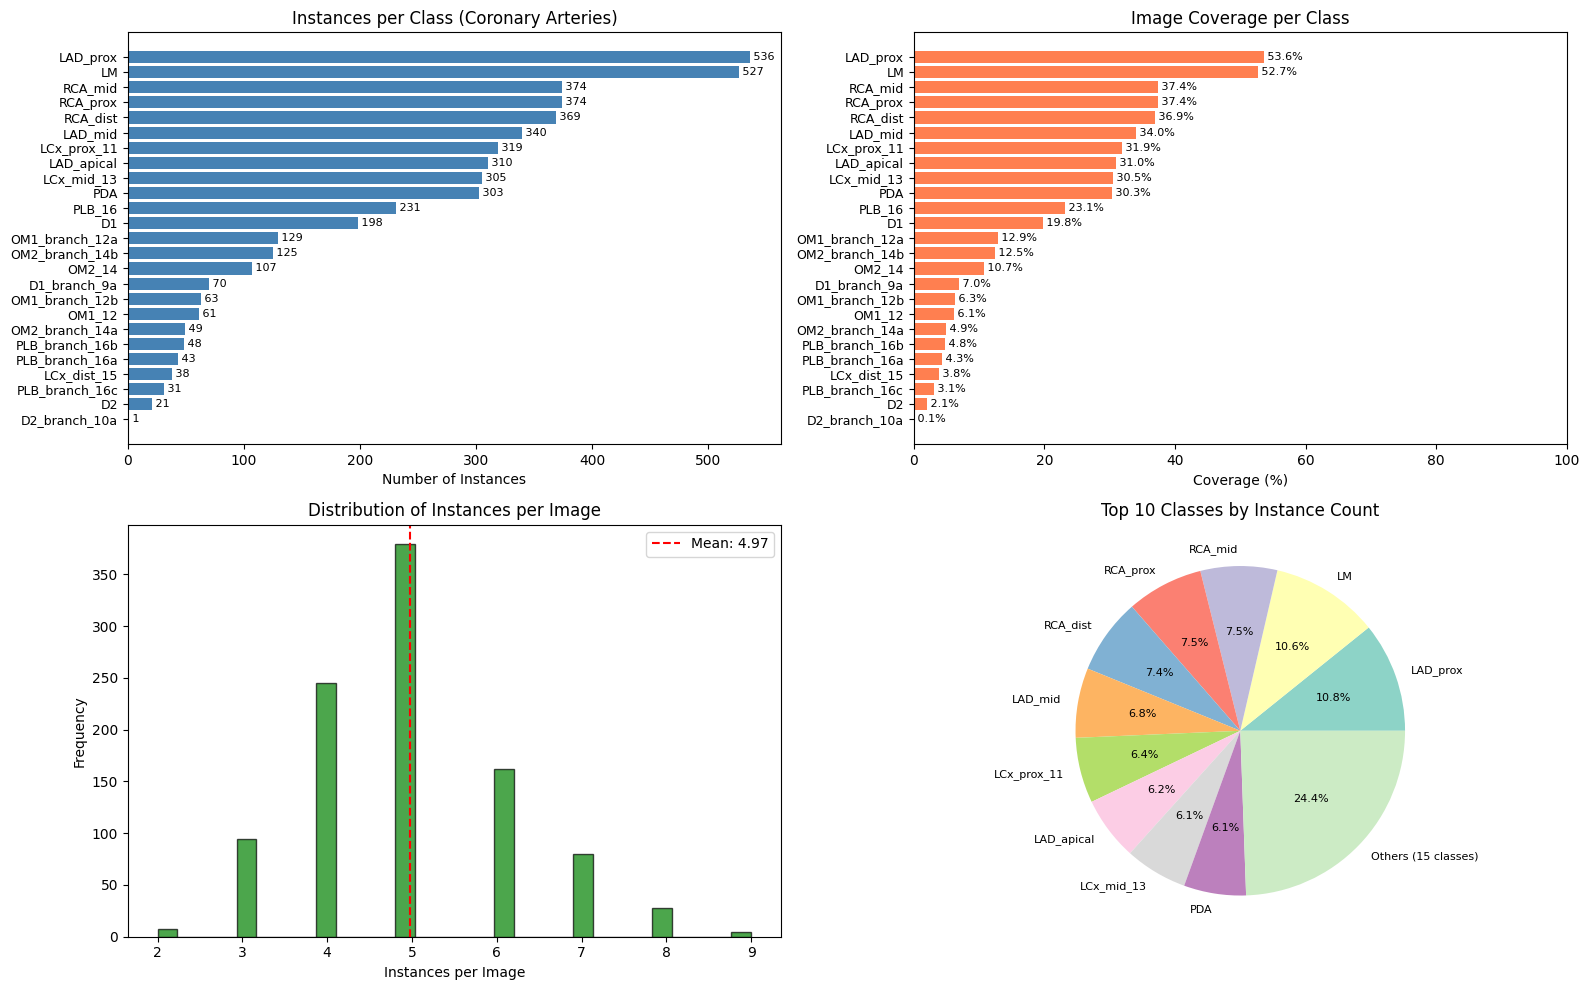


📊 Visualization Summary:
   Most frequent class:  LAD_prox (536 instances)
   Least frequent class: D2_branch_10a (1 instances)
   Highest coverage:     LAD_prox (53.6%)
   Lowest coverage:      D2_branch_10a (0.1%)

📊 ANALIZA ZBIORU WALIDACYJNEGO
🔍 Analyzing dataset with 200 images...

📊 DATASET STATISTICS - ARCADE CORONARY ARTERIES

📈 GLOBAL STATISTICS:
   Total images:           200
   Total instances:        1020
   Instances per image:    5.10 ± 1.20
   Min instances/image:    2
   Max instances/image:    9
   Unique classes:         24

🫀 PER-CLASS STATISTICS (CORONARY ARTERIES):
--------------------------------------------------------------------------------
Class                                  Instances     Images    Avg/Image   Coverage %
--------------------------------------------------------------------------------
1: RCA_prox                                   66         66         1.00        33.0%
2: RCA_mid                                    66         66         1.00

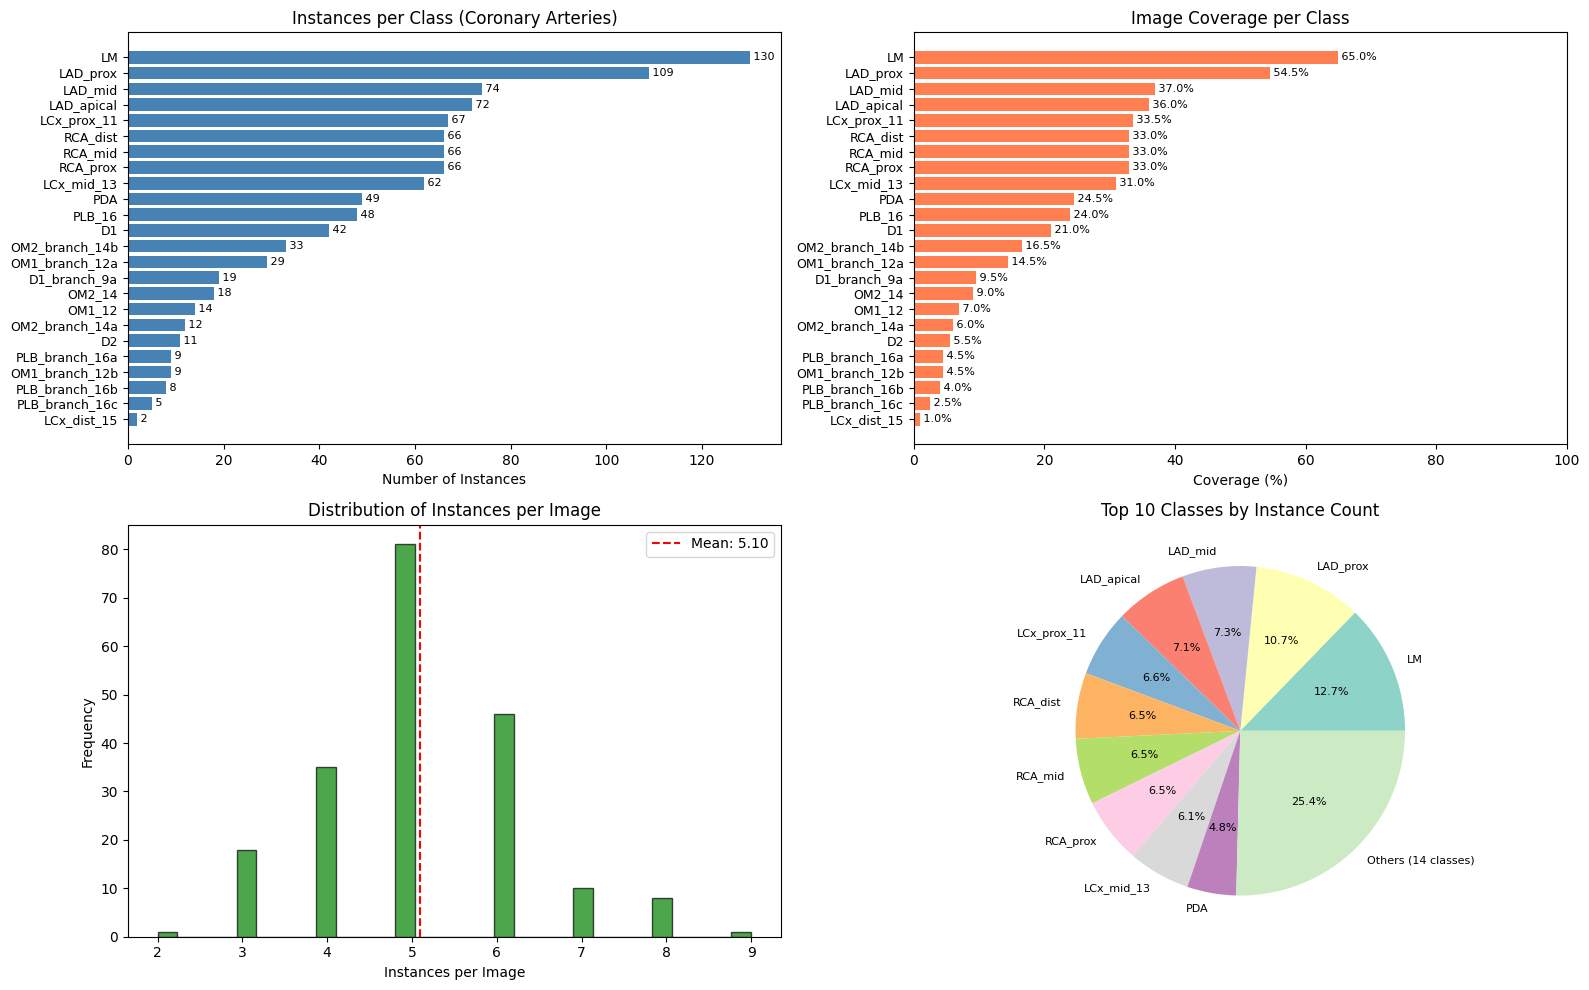


📊 Visualization Summary:
   Most frequent class:  LM (130 instances)
   Least frequent class: LCx_dist_15 (2 instances)
   Highest coverage:     LM (65.0%)
   Lowest coverage:      LCx_dist_15 (1.0%)

📊 ANALIZA ZBIORU TESTOWEGO
🔍 Analyzing dataset with 300 images...

📊 DATASET STATISTICS - ARCADE CORONARY ARTERIES

📈 GLOBAL STATISTICS:
   Total images:           300
   Total instances:        1670
   Instances per image:    5.57 ± 1.18
   Min instances/image:    2
   Max instances/image:    9
   Unique classes:         24

🫀 PER-CLASS STATISTICS (CORONARY ARTERIES):
--------------------------------------------------------------------------------
Class                                  Instances     Images    Avg/Image   Coverage %
--------------------------------------------------------------------------------
1: RCA_prox                                  100        100         1.00        33.3%
2: RCA_mid                                   100        100         1.00        33.3%
3: RCA

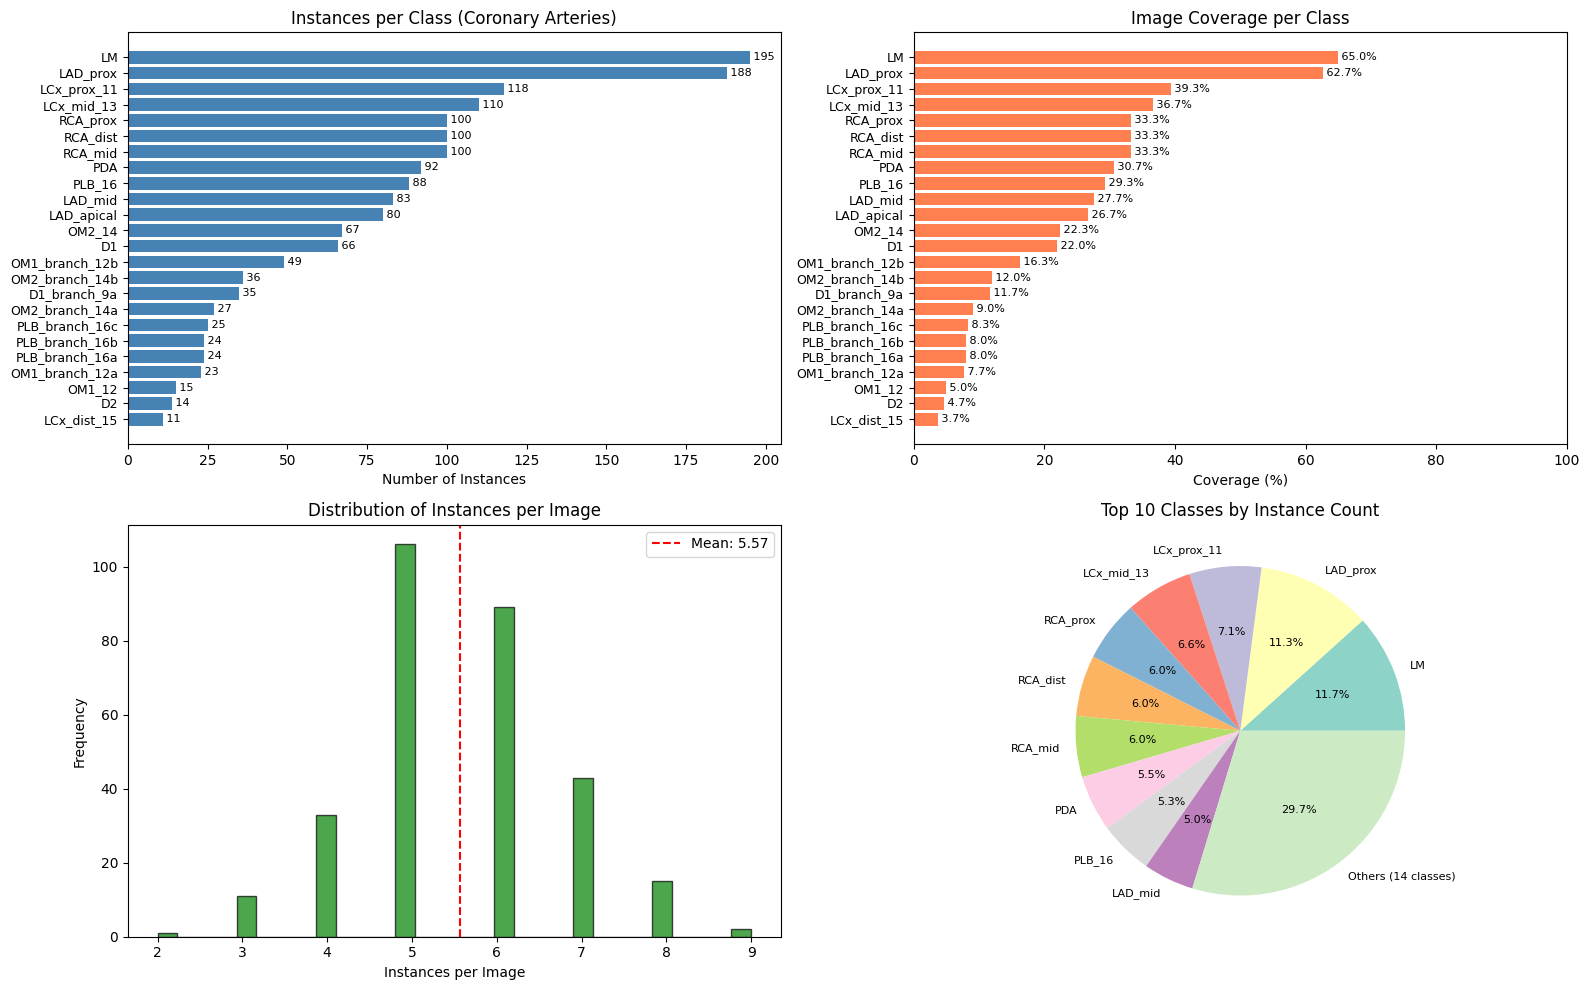


📊 Visualization Summary:
   Most frequent class:  LM (195 instances)
   Least frequent class: LCx_dist_15 (11 instances)
   Highest coverage:     LM (65.0%)
   Lowest coverage:      LCx_dist_15 (3.7%)

📈 PORÓWNANIE ZBIORÓW

Split               Images    Instances    Avg Inst/Img    Classes
--------------------------------------------------------------------------------
Train                 1000         4972            4.97         25
Valid                  200         1020            5.10         24
Test                   300         1670            5.57         24
--------------------------------------------------------------------------------
TOTAL                 1500         7662


In [16]:
# ============================================================================
# 🚀 ANALIZA STATYSTYK DATASETU
# ============================================================================

# Załaduj dataset (użyj tego samego co do ewaluacji)
ds_train = COCOSegmentationDataset(
    images_dir="./arcade_coco_detection2/train",
    annotations_path="./arcade_coco_detection2/train/_annotations.coco.json"
)

ds_val = COCOSegmentationDataset(
    images_dir="./arcade_coco_detection2/valid",
    annotations_path="./arcade_coco_detection2/valid/_annotations.coco.json"
)

ds_test = COCOSegmentationDataset(
    images_dir="./arcade_coco_detection2/test",
    annotations_path="./arcade_coco_detection2/test/_annotations.coco.json"
)

# Nazwy klas (tętnice wieńcowe)
CLASS_NAMES = {
    1: "RCA_prox",
    2: "RCA_mid",
    3: "RCA_dist",
    4: "PDA",
    5: "LM",
    6: "LAD_prox",
    7: "LAD_mid",
    8: "LAD_apical",
    9: "D1",
    10: "D1_branch_9a",
    11: "D2",
    12: "D2_branch_10a",
    13: "LCx_prox_11",
    14: "OM1_12",
    15: "OM1_branch_12a",
    16: "LCx_mid_13",
    17: "OM2_14",
    18: "OM2_branch_14a",
    19: "LCx_dist_15",
    20: "PLB_16",
    21: "PLB_branch_16a",
    22: "PLB_branch_16b",
    23: "PLB_branch_16c",
    24: "OM1_branch_12b",
    25: "OM2_branch_14b",
}

print("=" * 80)
print("📊 ANALIZA ZBIORU TRENINGOWEGO")
print("=" * 80)
stats_train = analyze_dataset_statistics(ds_train, class_names=CLASS_NAMES, verbose=True)
print_dataset_statistics(stats_train)
plot_dataset_statistics(stats_train, figsize=(16, 10))

print("\n" + "=" * 80)
print("📊 ANALIZA ZBIORU WALIDACYJNEGO")
print("=" * 80)
stats_val = analyze_dataset_statistics(ds_val, class_names=CLASS_NAMES, verbose=True)
print_dataset_statistics(stats_val)
plot_dataset_statistics(stats_val, figsize=(16, 10))

print("\n" + "=" * 80)
print("📊 ANALIZA ZBIORU TESTOWEGO")
print("=" * 80)
stats_test = analyze_dataset_statistics(ds_test, class_names=CLASS_NAMES, verbose=True)
print_dataset_statistics(stats_test)
plot_dataset_statistics(stats_test, figsize=(16, 10))

# Podsumowanie porównawcze
print("\n" + "=" * 80)
print("📈 PORÓWNANIE ZBIORÓW")
print("=" * 80)
print(f"\n{'Split':<15} {'Images':>10} {'Instances':>12} {'Avg Inst/Img':>15} {'Classes':>10}")
print("-" * 80)
print(f"{'Train':<15} {stats_train.total_images:>10} {stats_train.total_instances:>12} "
      f"{stats_train.mean_instances_per_image:>15.2f} {len(stats_train.class_counts):>10}")
print(f"{'Valid':<15} {stats_val.total_images:>10} {stats_val.total_instances:>12} "
      f"{stats_val.mean_instances_per_image:>15.2f} {len(stats_val.class_counts):>10}")
print(f"{'Test':<15} {stats_test.total_images:>10} {stats_test.total_instances:>12} "
      f"{stats_test.mean_instances_per_image:>15.2f} {len(stats_test.class_counts):>10}")
print("-" * 80)
total_images = stats_train.total_images + stats_val.total_images + stats_test.total_images
total_instances = stats_train.total_instances + stats_val.total_instances + stats_test.total_instances
print(f"{'TOTAL':<15} {total_images:>10} {total_instances:>12}")
print("=" * 80)

In [ ]:
# 🚀 URUCHOM EWALUACJĘ NA ZBIORZE TESTOWYM
# Upewnij się, że model i ds (dataset) są załadowane

# Jeśli nie masz jeszcze załadowanego datasetu:
# ds = sv.DetectionDataset.from_coco(
#     images_directory_path="./arcade_coco_dataset_seg/test",
#     annotations_path="./arcade_coco_dataset_seg/test/_annotations.coco.json",
# )

# Uruchom ewaluację
metrics = evaluate_segmentation_on_dataset(
    model=model,
    dataset=ds,
    threshold=0.5,
    num_classes=26,
    verbose=True
)

# Wyświetl raport
print_evaluation_report(
    metrics=metrics,
    class_names=model.class_names if hasattr(model, 'class_names') else None,
    show_per_class=True
)

# Wizualizacja per-class
plot_per_class_metrics(
    metrics=metrics,
    class_names=model.class_names if hasattr(model, 'class_names') else None
)

## 📊 Analiza maxDets dla ARCADE Dataset

Parametr `maxDets` w pycocotools określa maksymalną liczbę detekcji na obraz branych pod uwagę przy ewaluacji.

**Domyślne wartości:** `[1, 10, 100]`

**Problem dla ARCADE:**
- Dataset ma 25-26 klas segmentów naczyń wieńcowych
- Na jednym obrazie może być 10-40+ instancji (segmenty tętnic)
- Jeśli `maxDets < liczba_obiektów`, część detekcji jest ignorowana → zaniżone metryki

In [ ]:
# 📊 ANALIZA ROZKŁADU LICZBY OBIEKTÓW PER OBRAZ W ARCADE
# Sprawdź ile obiektów jest na obrazach, żeby dobrać odpowiedni maxDets

from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analyze_objects_per_image(coco_json_path: str) -> dict:
    """
    Analyze distribution of objects per image in COCO dataset.
    
    Returns dict with statistics useful for setting maxDets parameter.
    """
    coco = COCO(coco_json_path)
    
    # Count objects per image
    objects_per_image = []
    for img_id in coco.getImgIds():
        ann_ids = coco.getAnnIds(imgIds=img_id)
        objects_per_image.append(len(ann_ids))
    
    objects_per_image = np.array(objects_per_image)
    
    stats = {
        "num_images": len(objects_per_image),
        "total_objects": int(objects_per_image.sum()),
        "min": int(objects_per_image.min()),
        "max": int(objects_per_image.max()),
        "mean": float(objects_per_image.mean()),
        "median": float(np.median(objects_per_image)),
        "std": float(objects_per_image.std()),
        "p90": float(np.percentile(objects_per_image, 90)),
        "p95": float(np.percentile(objects_per_image, 95)),
        "p99": float(np.percentile(objects_per_image, 99)),
    }
    
    # Suggested maxDets values
    stats["suggested_maxDets"] = [
        1, 
        10, 
        int(np.ceil(stats["p99"] / 10) * 10),  # Round up to nearest 10
        max(100, int(np.ceil(stats["max"] / 50) * 50))  # At least 100, round to 50
    ]
    
    return stats, objects_per_image


def plot_objects_distribution(objects_per_image: np.ndarray, title: str = ""):
    """Plot histogram of objects per image with maxDets thresholds."""
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Histogram
    ax.hist(objects_per_image, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    
    # Add vertical lines for common maxDets values
    maxDets_values = [10, 100, 200, 300]
    colors = ['red', 'orange', 'green', 'purple']
    
    for md, color in zip(maxDets_values, colors):
        ax.axvline(x=md, color=color, linestyle='--', linewidth=2, 
                   label=f'maxDets={md}')
    
    # Mark percentiles
    p95 = np.percentile(objects_per_image, 95)
    p99 = np.percentile(objects_per_image, 99)
    ax.axvline(x=p95, color='cyan', linestyle=':', linewidth=2, label=f'P95={p95:.0f}')
    ax.axvline(x=p99, color='magenta', linestyle=':', linewidth=2, label=f'P99={p99:.0f}')
    
    ax.set_xlabel('Liczba obiektów na obraz')
    ax.set_ylabel('Liczba obrazów')
    ax.set_title(f'{title}\nRozkład liczby obiektów per obraz')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendation
    max_objects = objects_per_image.max()
    print(f"\n📌 REKOMENDACJA dla maxDets:")
    print(f"   Max obiektów na obraz: {max_objects}")
    print(f"   95 percentyl: {p95:.0f}")
    print(f"   99 percentyl: {p99:.0f}")
    
    if max_objects > 100:
        recommended = int(np.ceil(max_objects / 50) * 50)  # Round up to 50
        print(f"\n   ⚠️ maxDets=100 może być za mało!")
        print(f"   ✅ Zalecane: maxDets >= {recommended}")
        print(f"\n   W pycocotools ustaw: params.maxDets = [1, 10, {recommended}]")
    else:
        print(f"\n   ✅ Domyślne maxDets=100 powinno wystarczyć")


# Analiza dla ARCADE dataset
# Zmień ścieżkę na swój dataset
ARCADE_COCO_PATH = "./arcade_coco_detection/test/_annotations.coco.json"

try:
    stats, objects_per_image = analyze_objects_per_image(ARCADE_COCO_PATH)
    
    print("=" * 60)
    print("📊 STATYSTYKI ARCADE DATASET")
    print("=" * 60)
    print(f"   Liczba obrazów:     {stats['num_images']}")
    print(f"   Łączna liczba obj.: {stats['total_objects']}")
    print(f"   Min obj/obraz:      {stats['min']}")
    print(f"   Max obj/obraz:      {stats['max']}")
    print(f"   Średnia:            {stats['mean']:.1f}")
    print(f"   Mediana:            {stats['median']:.0f}")
    print(f"   Odch. std:          {stats['std']:.1f}")
    print(f"   90 percentyl:       {stats['p90']:.0f}")
    print(f"   95 percentyl:       {stats['p95']:.0f}")
    print(f"   99 percentyl:       {stats['p99']:.0f}")
    print("=" * 60)
    
    plot_objects_distribution(objects_per_image, "ARCADE Coronary Vessels")
    
except Exception as e:
    print(f"⚠️ Nie można załadować: {ARCADE_COCO_PATH}")
    print(f"   Błąd: {e}")
    print(f"   Zmień ścieżkę ARCADE_COCO_PATH na właściwą lokalizację")

In [22]:
# 🔧 JAK ZMIENIĆ maxDets W PYCOCOTOOLS PODCZAS EWALUACJI
# 
# RF-DETR używa pycocotools do ewaluacji. Aby zmienić maxDets, masz kilka opcji:

# OPCJA 1: Modyfikacja po stworzeniu COCOeval
# ------------------------------------------
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def evaluate_with_custom_maxdets(
    gt_coco_path: str,
    pred_json_path: str, 
    max_dets: list = [1, 10, 300],
    iou_type: str = "bbox"
):
    """
    Ewaluacja COCO z niestandardowym maxDets.
    
    Args:
        gt_coco_path: Ścieżka do ground truth COCO JSON
        pred_json_path: Ścieżka do predikcji w formacie COCO results
        max_dets: Lista wartości maxDets [small, medium, large]
        iou_type: "bbox" lub "segm"
    
    Returns:
        COCOeval object with results
    """
    # Załaduj GT i predictions
    coco_gt = COCO(gt_coco_path)
    coco_dt = coco_gt.loadRes(pred_json_path)
    
    # Stwórz ewaluator
    coco_eval = COCOeval(coco_gt, coco_dt, iouType=iou_type)
    
    # 🔑 KLUCZOWE: Zmień maxDets PRZED evaluate()
    coco_eval.params.maxDets = max_dets
    
    # Uruchom ewaluację
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    return coco_eval


# OPCJA 2: Dla RF-DETR - modyfikacja w kodzie biblioteki
# -------------------------------------------------------
# W pliku rfdetr/datasets/coco_eval.py znajdź CocoEvaluator.__init__
# i zmień:
#   self.coco_eval[iou_type].params.maxDets = [1, 10, 300]  # zamiast [1, 10, 100]

# OPCJA 3: Monkey-patching przed treningiem
# ------------------------------------------
def patch_coco_eval_maxdets(max_dets: list = [1, 10, 300]):
    """
    Monkey-patch pycocotools aby używać niestandardowego maxDets.
    
    Wywołaj PRZED treningiem modelu.
    """
    from pycocotools import cocoeval
    
    original_init = cocoeval.COCOeval.__init__
    
    def patched_init(self, cocoGt=None, cocoDt=None, iouType='segm'):
        original_init(self, cocoGt, cocoDt, iouType)
        self.params.maxDets = max_dets
        print(f"🔧 COCOeval.maxDets ustawione na: {max_dets}")
    
    cocoeval.COCOeval.__init__ = patched_init
    print(f"✅ Patched COCOeval z maxDets={max_dets}")

# Użycie:
# patch_coco_eval_maxdets([1, 10, 300])
# model.train(...)  # Teraz ewaluacja użyje maxDets=[1, 10, 300]


print("📌 PODSUMOWANIE maxDets dla ARCADE:")
print("-" * 50)
print("• ARCADE ma ~25-26 klas naczyń wieńcowych")
print("• Typowo 10-40 instancji na obraz")
print("• Domyślne maxDets=100 zazwyczaj wystarcza")
print("• Jeśli masz >100 obiektów/obraz → zwiększ do 200-300")
print("-" * 50)
print("\n✅ Uruchom poprzednią komórkę, aby zobaczyć rozkład dla Twojego datasetu")

📌 PODSUMOWANIE maxDets dla ARCADE:
--------------------------------------------------
• ARCADE ma ~25-26 klas naczyń wieńcowych
• Typowo 10-40 instancji na obraz
• Domyślne maxDets=100 zazwyczaj wystarcza
• Jeśli masz >100 obiektów/obraz → zwiększ do 200-300
--------------------------------------------------

✅ Uruchom poprzednią komórkę, aby zobaczyć rozkład dla Twojego datasetu
